[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/prokaj/elte-python-2023/blob/main/2023-11-27.ipynb)   

Néhány import amit később használni fogunk:

In [266]:
import importlib
import math
import graphviz

if importlib.util.find_spec('ipytest') is None:
    ! pip install --quiet ipytest

import ipytest

ipytest.autoconfig()

# Házi feladatok

## 1. Maximum eloszlása szimmetrikus bolyongásnál

Szimmetrikus bolyongás alatt olyan véletlen sorozatot értünk, ami a nullából indul és minden lépése (megváltozása 1 vagy −1, 1/2–1/2 valószínűséggel a többi lépéstől függetlenül.

Írjunk egy függvényt, ami a numpy könyvtár függvényei segítségével elkészíti n hosszú bolyongásoknak egy m elemű sorozatát! Azaz a függvény kimenete egy $m\times n$ mátrix, az egyes sorok az egyes bolyongásokat írják le.

Rajzoljunk ki néhány bolyongást! Készítsünk hisztogramot a bolyongások utolsó pozíciójából (ez a függvény által visszakapott mátrix utolsó oszlopa). Valamint készítsünk hisztogramot a bolyongások maximális értékéből is (ezek a mátrixunk soronkénti maximumai). $n$ legyen legalább 100 és $m$ legalább 1000. Észreveszünk-e valami összefüggést az ábrák között?

A megoldás során jól jöhetnek a következő függvények:

```
import numpy as np
import matplotlib.pyplot as plt
np.random.binomial, np.cumsum, np.where, np.max
plt.plot, plt.hist, plt.title, plt.grid
```

In [6]:
import numpy as np 
import matplotlib.pyplot as plt

def random_walk(n, m=1):
    steps = 2*np.random.binomial(1, 0.5, size=(m, n-1))-1
    walk = np.zeros((m, n), dtype=np.int32)
    steps.cumsum(axis=1, out=walk[:,1:])
    return walk



In [7]:
random_walk(10)

array([[0, 1, 0, 1, 2, 1, 2, 1, 2, 1]], dtype=int32)

In [8]:
%%ipytest

def test_random_walk():
    rw = random_walk(10)
    assert rw.shape == (1,10)

    rw = random_walk(100)
    assert set(np.diff(rw[0])) == {-1, 1}

    rw = random_walk(100, 1000)
    assert (rw[:, 0]==0).all()
    
    

.                                                                                            [100%]
1 passed in 0.02s


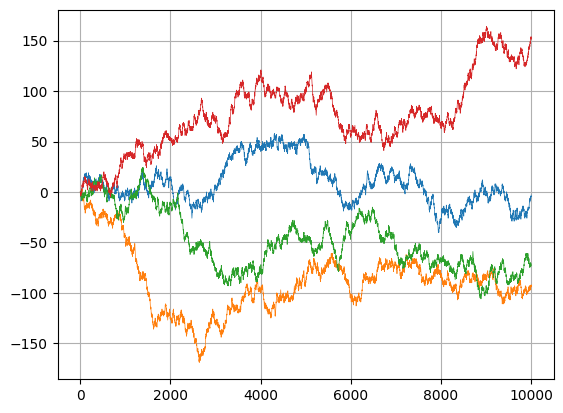

In [9]:
rw = random_walk(10000, 4)
for i in range(4):
    plt.plot(rw[i], linewidth=0.5)
plt.grid()
plt.show()

In [10]:
rw = random_walk(100, 200000)

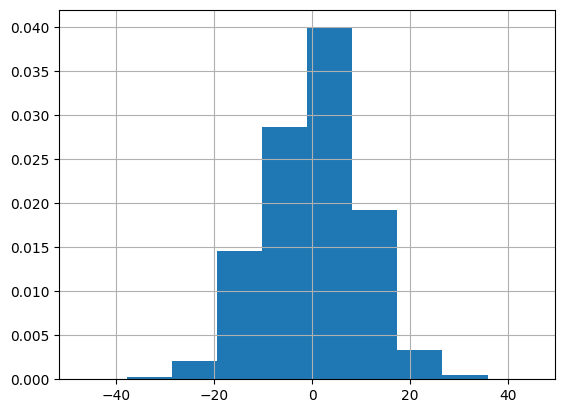

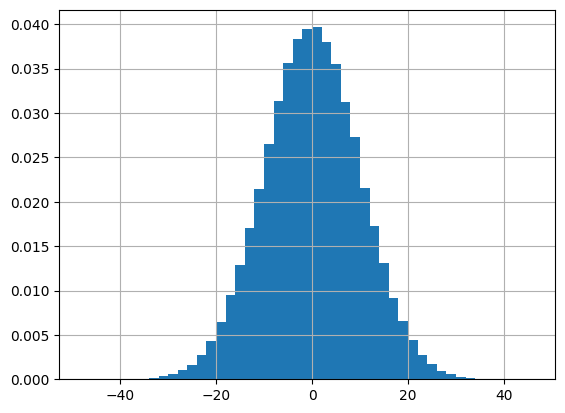

In [11]:
rw_last  =  rw[:, -1]
plt.hist(rw_last, density=True)
plt.grid()
plt.show()

bins = np.arange(rw_last.min()-1, rw_last.max()+2, 2)
plt.hist(rw_last, bins, density=True)
plt.grid()
plt.show()

(200000,)


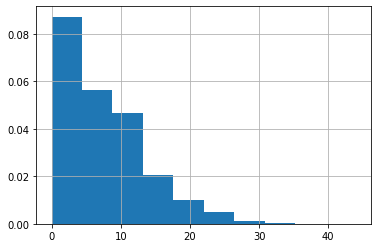

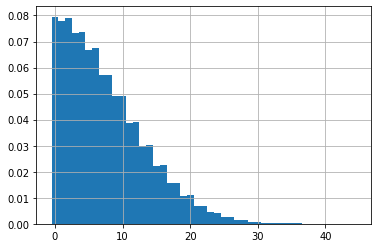

In [ ]:
rw_max = rw.max(axis=1)
print(rw_max.shape)

plt.hist(rw_max, density=True)
plt.grid()
plt.show()

bins = np.arange(rw_max.max()+2)-0.5
plt.hist(rw_max, bins, density=True)
plt.grid()
plt.show()

## Magyarázat

A két ábra nagyon hasonlít, a maximumok hisztogrammja olyan mint felső ábra pozitív fele.

A szimmetikus bolyongás egy véletlen sorozat, a szokásos jelölés $(S_k)_{0\leq k\leq n}$.

A maximum eloszlása pl. tükrözési elvvel számolható. $\ell\geq0$-ra:
$$
\mathbb{P}(\max_{k\leq n} S_k\geq x) = 
\mathbb{P}(\max_{k\leq n} S_k\geq x,\, S_n\geq x) +
\mathbb{P}(\max_{k\leq n} S_k\geq x,\, S_n<x)
$$
A második taggal kell foglalkozni. Nézzük azt az esetet, amikor $S_n=y< x$.

Minden lehetséges út egyformán valószínű ($1/2^n$). Így az  a kérdés, hány olyan út van ami $(0,0)$-ból $(n,y)$-ba, aminek maximuma legalább $x$. Az ilyen utak a *jó* utak.

Egy jó út esetén legyen $t$ az első olyan index, amikor az $x$ szinten jár, és a $t$ utáni lépéseket fordítsuk az ellentettjükre.

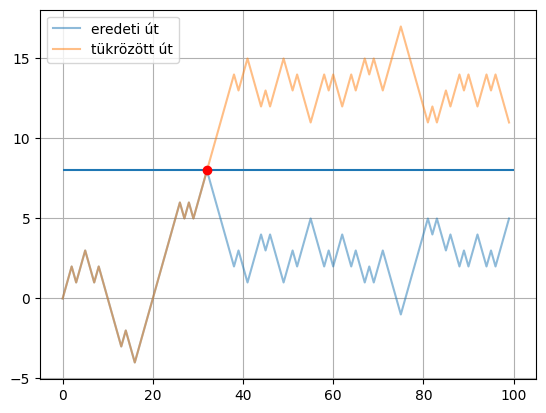

In [13]:
rw_max = rw.max(axis=1)
x = 8
idx = np.where((rw_last<x) & (rw_max>=x))[0]

if len(idx)>0:
    idx = idx.min()
    rw0 = rw[idx]
    t = np.where(rw0==x)[0].min()
    rw1 = np.zeros_like(rw0)
    rw1[:t+1] = rw0[:t+1]
    rw1[t+1:] = 2*rw0[t]-rw0[t+1:]
    plt.plot(rw0, label="eredeti út", alpha=0.5)
    plt.plot(rw1, label="tükrözött út", alpha=0.5)
    plt.hlines([x], 0, len(rw0))
    plt.plot(t, x, 'ro')
    plt.grid()
    plt.legend()


Ha $x\geq 0$ és $y<x$, akkor 
a fenti hozzárendelés bijekció azon utak között, amik $(0,0)$-ból $(n,y)$-ba mennek és közben járnak $x$ magasságban és azon utak között, amik 
$(0,0)$-ból $(n,2x-y)$ mennek. A tükrözött útból úgy kaphatjuk vissza az eredetit, hogy $t$ a tükrözött útból is megkapható, mint az első olyan index, amikor az $x$ szinten jár a bolyongás, és a $t$ utáni növekményeket $-1$-gyel szorozzuk.
$$
\begin{aligned}
\mathbb{P}(\max_{k\leq n} S_k\geq x) &= 
\mathbb{P}(\max_{k\leq n} S_k\geq x,\, S_n\geq x) +
\mathbb{P}(\max_{k\leq n} S_k\geq x,\, S_n<x)\\
&= \mathbb{P}(S_n\geq x) +
\mathbb{P}(S_n>x)
\end{aligned}
$$

Ebből
$$
\mathbb{P}(\max_{k\leq n} S_k = x) = \mathbb{P}(S_n = x) + \mathbb{P}(S_n = x+1)
$$


A *tükrözési elvből* valójában az jött ki, hogy:
$$
\mathbb{P}(\max_{k\leq n} S_k\geq x,\, S_n\leq y)= \mathbb{P}(S_n\geq 2x-y),\quad\text{ha $x\geq 0$ és $y\leq x$}
$$

Ebből, ha $x\geq 0$ és $y\leq x$
$$
\begin{aligned}
\mathbb{P}(\max_{k\leq n} S_k = x,\, S_n\leq y) &= \mathbb{P}(S_n\geq 2x-y)- \mathbb{P}(S_n\geq 2x-y+2)= \mathbb{P}(S_n = 2x-y)+\mathbb{P}(S_n = 2x-y+1)\\
\mathbb{P}(\max_{k\leq n} S_k = x,\, S_n = y) &= \mathbb{P}(S_n = 2x-y)+\mathbb{P}(S_n = 2x-y+1)- (\mathbb{P}(S_n = 2x-(y-1))+\mathbb{P}(S_n = 2x-(y-1)+1))\\
& = \mathbb{P}(S_n = 2x-y)-\mathbb{P}(S_n = 2x-y+2)
\end{aligned}
$$


A `plt.hist` függvény használata helyett célszerű magunknak kigyűjteni a gyakoriságokat.

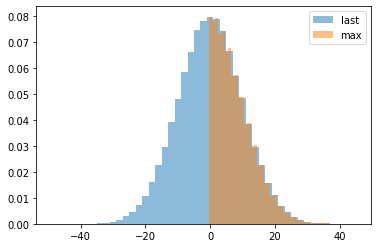

In [ ]:
rw_last_values, rw_last_cnts = np.unique(rw_last, return_counts=True)
rw_last_probs = rw_last_cnts/rw_last_cnts.sum()

rw_max_values, rw_max_cnts = np.unique(rw_max, return_counts=True)
rw_max_probs = rw_max_cnts/rw_max_cnts.sum()

plt.bar(rw_last_values, rw_last_probs, width=2, alpha=0.5, label='last')
plt.bar(rw_max_values, rw_max_probs, width=1, alpha=0.5, label='max')
plt.legend()
plt.show()

Be tudjuk-e rajzolni a haranggörbét?

Ehhez egyrészt használhatjuk a `scipy.stats` `norm` objektumának `pdf` (probablity density function) metódusát. Vagy megírhatjuk magunk is.

Vegyük észre, hogy 100 lépés után az átlag 0  a szórás $10=\sqrt{100}$. Pl. az mintában amit generáltunk ezek az értékek:

In [ ]:
print(f"minta átlag = {rw_last.mean():.3f}, minta szórása={rw_last.std():.3f}")

minta átlag = -0.028, minta szórása=9.989


In [ ]:
from scipy.stats import norm as gauss

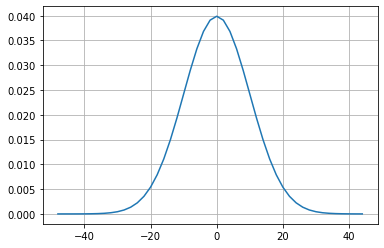

In [ ]:
sigma = (rw.shape[1]-1)**0.5
plt.plot(rw_last_values, gauss.pdf(rw_last_values, 0, sigma))
plt.grid()
plt.show()

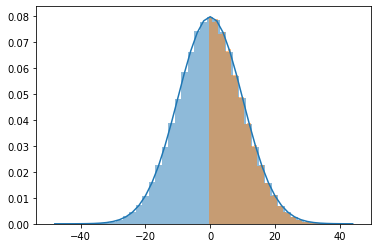

In [ ]:
plt.bar(rw_last_values, rw_last_probs, width=2, alpha=0.5)
plt.bar(rw_max_values, rw_max_probs, width=1, alpha=0.5)
plt.plot(rw_last_values, 2*gauss.pdf(rw_last_values, 0, sigma))
plt.show()

## 2. Ugyanez minimummal. 

## 3. Utolsó nullhely.

Szimmetrikus bolyongás alatt olyan véletlen sorozatot értünk, ami a nullából indul és minden lépése (megváltozása) 1 vagy −1, 1/2–1/2
valószínűséggel a többi lépéstől függetlenül.

Írjunk egy függvényt, ami a numpy könyvtár függvényei segítségével elkészíti $n$
hosszú bolyongásoknak egy $m$ elemű sorozatát! Azaz a függvény kimenete egy $m\times n$
mátrix, az egyes sorok az egyes bolyongásokat írják le.

Rajzoljunk ki néhány bolyongást!

A következő részhez $n$ legyen legalább 100 és $m$ legalább 1000.

Minden bolyongásra számoljuk ki az utolsó nulla érték indexét és ezt osszuk el a bolyongás hosszával. Készítsünk hisztogramot az így kapott értékekből.

Extra kérdés, a pontozásba nem számít bele: Van-e olyan szép függvény, ami illeszkedik a hisztogram alakjára.

In [ ]:
np.nonzero?

In [ ]:
np.where(rw[0]==0)[0]

array([ 0,  2,  8, 14, 16, 20, 24, 32, 34, 36, 38, 68, 82, 86, 90])

A bolyongás legyártásában nincs különbség. Az utolsó nullhelyet nehézkesebb csak array műveletekkel számolni.

In [18]:
def last_zero(rw):
    return np.array([np.where(row==0)[0].max() for row in rw])

def last_zero_2(rw):
    return ((rw==0)*np.arange(0, rw.shape[1])).max(axis=1)


In [19]:
%%ipytest

def last_zero_row(row):
    idx = 0
    for i, x in enumerate(row):
        if x==0:
            idx = i
    return idx

def last_zero_with_for(rw):
    return np.array([last_zero_row(row) for row in rw])
    

def test_last_zero():
    rw = random_walk(100,1000)
    assert (last_zero(rw) == last_zero_with_for(rw)).all()
    assert (last_zero_2(rw) == last_zero_with_for(rw)).all()
    

.                                                                                            [100%]
1 passed in 0.29s


0.0, 1.0


(array([39566., 18246., 17561., 10461., 12833., 15237., 13169., 11847.,
        17274., 43806.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

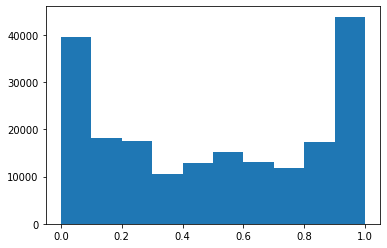

In [ ]:

rw_last_zero = last_zero(rw)/(rw.shape[1]-1)
print(f"{rw_last_zero.min()}, {rw_last_zero.max()}")
plt.hist(rw_last_zero)


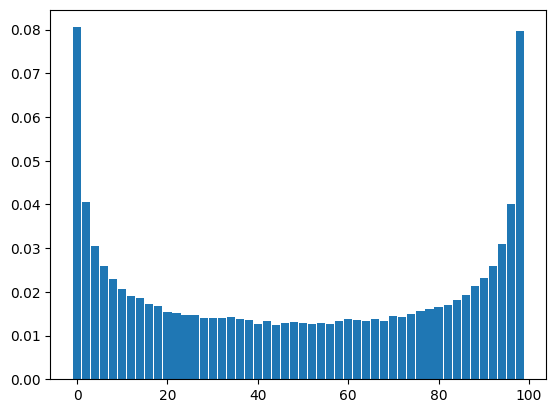

In [21]:
rw_last_zero = last_zero_2(rw)
rw_last_zero_values, rw_last_zero_cnts = np.unique(rw_last_zero, return_counts=True)
rw_last_zero_probs = rw_last_zero_cnts/rw_last_zero_cnts.sum()
width = np.diff(rw_last_zero_values).max()
plt.bar(rw_last_zero_values, rw_last_zero_probs, width=0.9*width)
plt.show()

## Magyarázat.

A fenti számolásból
$$
    \mathbb{P}(S_{1}\geq 0, \dots S_n\geq 0) = \mathbb{P}(\min_{k\leq n} S_k\geq 0) = \mathbb{P}(\max_{k\leq n} S_k\leq 0) = \mathbb{P}(\max_{k\leq n} S_k= 0) = \mathbb{P}(S_n=0)+\mathbb{P}(S_n=1) = \mathbb{P}(S_n=0)+\mathbb{P}(S_{n+1}=0) 
$$

Innen 
$$
    \mathbb{P}(S_{1}> 0, \dots S_n> 0) = \frac12\mathbb{P}(\min_{k\leq n} S_k-S_1\geq 0) = \frac12\left(\mathbb{P}(S_{n-1}=0)+\mathbb{P}(S_{n}=0)\right)
$$
és 
$$
    \mathbb{P}(S_{1}\neq 0, \dots S_n\neq 0) = 
    \mathbb{P}(S_{1}> 0, \dots S_n> 0)+\mathbb{P}(S_{1}< 0, \dots S_n< 0) = \mathbb{P}(S_{n-1}=0)+\mathbb{P}(S_{n}=0)
$$

Legyen $n=2k$ páros és $T_n$ az utolsó nullhely az első $n$ lépés során
$$
    \mathbb{P}(T_n = 2\ell)=
    \mathbb{P}(S_{2\ell}=0,\, S_{2\ell+i}-S_{2\ell}\neq 0,\, i=1,\dots,2k-2\ell)
    =\mathbb{P}(S_{2\ell}=0)\mathbb{P}(S_{2(n-\ell)}=0)
    =\frac{1}{2^{2\ell}}\binom{2\ell}{\ell}\frac{1}{2^{2(k-\ell)}}\binom{2(k-\ell)}{k-\ell}
$$

HF középiskolából: rekurzió $I_k = \int_0^{\pi/2}\cos^k(\alpha)d\alpha$. Ha ezt felírjuk, kihasználjuk, hogy $I_0=\pi/2$, $I_1=1$, akkor azt kapjuk, hogy
$$
    \frac1{\sqrt{\pi(k+1/2)}}\leq \frac{1}{2^{2k}}\binom{2k}{k}\leq \frac{1}{\sqrt{\pi k}},
    \quad
    \frac1{\sqrt{\pi(k+1/4)}}\approx \frac{1}{2^{2k}}\binom{2k}{k}
$$

Azaz 

$$
    \mathbb{P}(T_n=2\ell) \approx \frac{2}{n}\left.\frac{1}{\pi}\cdot\frac1{\sqrt{x(1-x)}}\right|_{x=\frac{2\ell}{n}}
$$

,,Ellenőrizzük'' a kapott formulát 

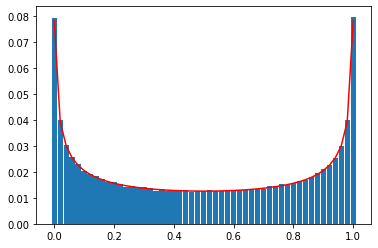

In [ ]:
def arcsin_probs(x):
    width = np.diff(rw_last_zero_values).max()
    d = np.zeros_like(x)
    y = (x+0.33*width)*(1-x+0.33*width)
    d[y>0] = width/(np.sqrt(y[y>0])*np.pi)
    return d
    
plt.bar(rw_last_zero_values, rw_last_zero_probs, width=0.9*width)
plt.plot(rw_last_zero_values, arcsin_probs(rw_last_zero_values), color='red')
plt.show()

## Variációk

Tudunk-e cummulative maximumot számolni `numpy` segítségével? 

Ilyen függvényt nem találunk, de teszőleges `ufunc`-ból lehet **accumulált** változatot készíteni.

## Kitérő: `np.ufunc` Univerzális tömb függvények

In [734]:
[method for method in dir(np.ufunc) if not method.startswith("_")]

['accumulate',
 'at',
 'identity',
 'nargs',
 'nin',
 'nout',
 'ntypes',
 'outer',
 'reduce',
 'reduceat',
 'resolve_dtypes',
 'signature',
 'types']

In [741]:
def short_help(f):

    i = f.__doc__.find("Parameters")
    return f.__doc__ if i<0 else f.__doc__[:i]

print(short_help(np.ufunc.accumulate))
print(short_help(np.ufunc.at))
print(short_help(np.ufunc.outer))
print(short_help(np.ufunc.reduce))
print(short_help(np.ufunc.reduceat))




accumulate(array, axis=0, dtype=None, out=None)

    Accumulate the result of applying the operator to all elements.

    For a one-dimensional array, accumulate produces results equivalent to::

      r = np.empty(len(A))
      t = op.identity        # op = the ufunc being applied to A's  elements
      for i in range(len(A)):
          t = op(t, A[i])
          r[i] = t
      return r

    For example, add.accumulate() is equivalent to np.cumsum().

    For a multi-dimensional array, accumulate is applied along only one
    axis (axis zero by default; see Examples below) so repeated use is
    necessary if one wants to accumulate over multiple axes.

    
at(a, indices, b=None, /)

    Performs unbuffered in place operation on operand 'a' for elements
    specified by 'indices'. For addition ufunc, this method is equivalent to
    ``a[indices] += b``, except that results are accumulated for elements that
    are indexed more than once. For example, ``a[[0,0]] += 1`` will only
    inc

In [687]:
np.maximum.accumulate(rw)

array([ 0,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  6,  7,  8,
        9,  9,  9,  9,  9,  9,  9, 10, 11, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
      dtype=int32)

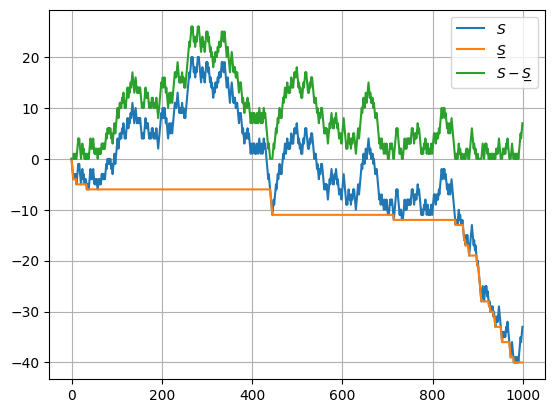

In [745]:
rw = random_walk(1000)[0]
running_min = np.minimum.accumulate(rw, axis=-1)
# rw.shape, running_min.shape
plt.plot(rw, label="$S$")
plt.plot(running_min, label="$S$\u0332")
plt.plot(rw-running_min, label="$S-S\u0332$")
# plt.plot(rw-2*running_min, label="$S-2S\u0332$")
plt.legend()
plt.grid()
plt.show()

Tegyük fel, hogy több lépést akarunk nézni és nem akarunk `n x repeat` méretű tömböt lefoglalni. 

In [32]:
def rw_last_max(n, repeat=1):
    val = np.zeros(repeat, dtype=np.int32)
    max_val = val.copy()
    for _ in range(n):
        val += 2*np.random.binomial(1, 0.5, size=repeat)-1
        np.maximum(max_val, val, out=max_val)
    rsqrtn = n**(-0.5)
    return val*rsqrtn, max_val*rsqrtn

In [677]:
val, max_val = rw_last_max(10_000, 10_000)

# Öröklődés

Előadáson szerepelt ehhez hasonló példa. Legyenek `Polygon`, `Rectangle`, `Square` osztályaink.
Minden négyzet téglalap és minden téglalap sokszög. Egy sokszöget a csúcsok felsorolásával adhatunk meg.
Ebből a kerület, terület kiszámolható és eldönthető, hogy a sokszög konvex-e. Ha akarjuk pl. a `Matplotlib` könyvtárral ki is rajzolhatjuk a sokszöget.

Menetközben síkvektorokkal akarunk számolni. Erre kényelmes a `numpy` könyvtárat használni.

In [14]:
import math
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt


In [ ]:

class Point(np.ndarray):
    def __new__(cls, point):
        point = np.asarray(point)
        assert point.shape[-1] == 2
        return point.view(cls)
    
    def __repr__(self):
        if self.ndim > 1:
            return f"Array of Points" 
        else:
            a, b =  self
        return f"Point{(a,b)}"

In [ ]:
Point((1,2))-Point((3,4))

Point(-2, -2)

In [47]:

class Polygon:

    def __init__(self, nodes):
        self.nodes = list(Point(node) for node in nodes)

    def area(self):
        nodes = np.array(self.nodes)
        nodes = nodes-nodes[0]
        area = 0
        for v1, v2 in zip(nodes[1:], nodes[2:]):
            area += v1[0]*v2[1]-v1[1]*v2[0]
        return abs(area)/2
        
    def perimeter(self):
        total = 0
        p0 = self.nodes[-1]
        for p in self.nodes:
            total += np.linalg.norm(p-p0)
            p0 = p
        return total

    def is_convex(self):
        nodes = np.array(self.nodes + self.nodes[:1])
        edges = np.diff(nodes, axis=0)
        idx = np.array([i%len(edges) for i in range(1, len(edges)+1)])
        edges1 = edges[idx]
        sgn = (rotate90(edges) * edges1).sum(axis=1)
        return (min(sgn)*max(sgn)>=0)

    def draw(self,  *args, fill=False, **kwargs):
        nodes = self.nodes + self.nodes[:1]
        x, y = np.array(nodes).T
        if fill:
            plt.fill(x, y, alpha=0.5)
        plt.plot(x, y, *args, **kwargs)
        plt.axis('equal')

    def __repr__(self):
        return f'{type(self).__name__}({[tuple(x) for x in self.nodes]})'


def rotate90(x):
    return np.flip(x, -1)*np.array([-1, 1])

class Rectangle(Polygon):

    def __init__(self, P1, P2, r):
        """
        P1, P2 froms an edge and r is the ratio of edge lengths.

        Assuming that e is P1P2 rotated counterclockwise by 90 degree
        the vertices are:
        P1, P2, P2+r*e, P1+r*e
        """
        P1, P2 = Point(P1), Point(P2)
        v = rotate90(P2-P1)*r
        super(Rectangle, self).__init__([P1, P2, P2+v, P1+v])


class Square(Rectangle):

    def __init__(self, P1, P2):
        super(Square, self).__init__(P1, P2, 1)



In [ ]:
rotate90(np.array([[0, 1],[1,0]]))

array([[-1,  0],
       [ 0,  1]])

In [ ]:
points = np.array([[0,0], [1,1]])
s = Square(points[0], points[1])
t = Rectangle(points[0], points[1], 2)
p = Polygon(points)
for x in [s, t, p]:
    print(f"{x} kerület: {x.perimeter():.2f}, konvex: {x.is_convex()}, terület: {x.area():.2f}")


Square([(0, 0), (1, 1), (0, 2), (-1, 1)]) kerület: 5.66, konvex: True, terület: 2.00
Rectangle([(0, 0), (1, 1), (-1, 3), (-2, 2)]) kerület: 8.49, konvex: True, terület: 4.00
Polygon([(0, 0), (1, 1)]) kerület: 2.83, konvex: True, terület: 0.00


Vegyük észre, hogy az `__repr__` metódust csak egyszer implementáltuk, mégis minden egyednek a saját típusát írja ki!
Az előző kód blokkot futtassuk le azután is, hogy a `draw` metódust implementáltuk.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Polygon([(0, 0), (2, 0), (2, 2), (1, 1), (0, 2), (1, 2), (0, 1)]) konvex?: False, p.area()=2.5


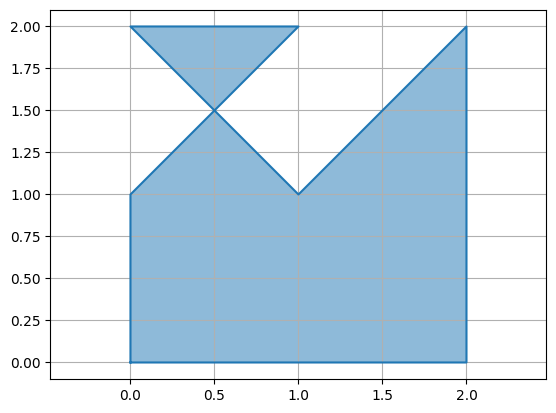

In [818]:
points = np.array([[0,0], [2,0], [2,2], [1,1], [0,2], [1,2], [0,1]])
p = Polygon(list(points))
print(f"{p} konvex?: {p.is_convex()}, {p.area()=}")
p.draw(fill=True)
plt.grid()
plt.show()


(-1.1, 1.1, -0.1, 2.1)

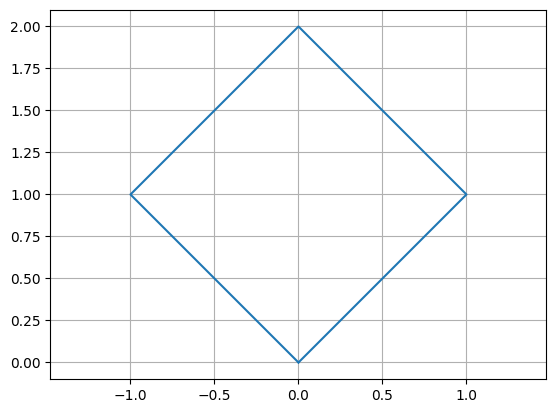

In [ ]:
plt.plot(*np.array(s.nodes)[[0,1,2,3,0]].T)
plt.grid()
plt.axis('equal')
# plt.axis('off')


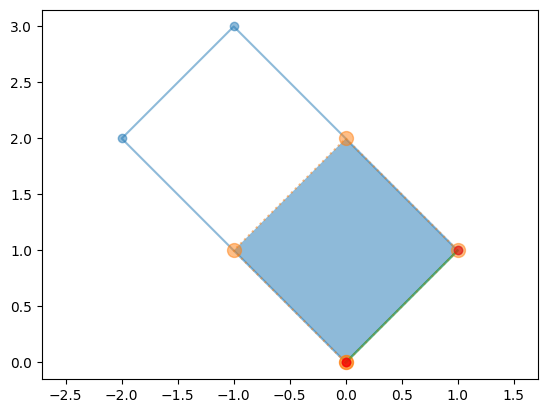

In [ ]:
t.draw('o-', alpha=0.5)
s.draw('o:', markersize=10, alpha=0.5, fill=True)
p.draw('o-', mfc="r", mec='r', alpha=0.5)
plt.show()

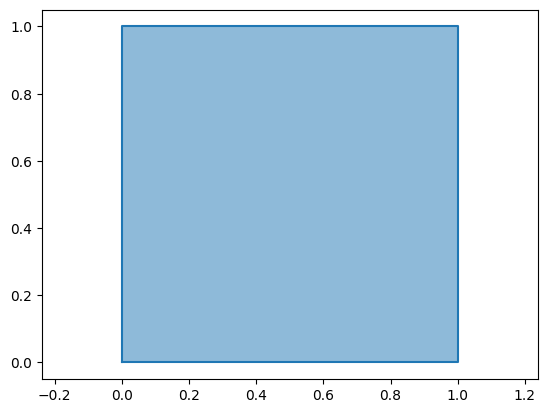

In [ ]:
p = Square([0,0], [1,0])
p.draw(fill=True)

# `with` statement


## Mi történik a `with` statement alkalmazásakor?

### Mit lehet a with mögé írni?

Hasonlóan a `for`-hoz szinte bármit, aminek van két metódusa:

- `__enter__`
- `__exit__`

```python
with obj as x:
    do_something with x
```

Itt az `obj.__enter__()` hívás eredménye lesz az x értéke és a block végén **GARANTÁLTAN** végrehajtódik az `obj.__exit__(...)` hívás.
Az `__enter__` metódus végezheti az előkészítést, az `__exit__` a takarítást!

### Kell-e nekünk ezeket a metódusokat közvetlenül implementálni?

Valójában nem. Elegendő egy generátor függvényt megírni:

```python
import time

def timer():
    try:
        start = time.time()
        yield

    finally:
        runtime = time.time() - start
        print(f"run time: {runtime:3f}")
```
            

Így még csak egy generátort kapunk ami egyszer visszaad semmit (`None`), majd a következő iterációnál jelzi, hogy vége van a sorozatnak.

Próbáljuk ki `for`-ral

In [ ]:
import time

def timer():
    try:
        start = time.time()
        yield

    finally:
        runtime = time.time() - start
        print(f"run time: {runtime:3f}")

for x in timer():
    print(x)

None
run time: 0.000077


`with`-del hibát kapunk

In [ ]:
with timer() as x:
    print(x)

AttributeError: __enter__

A `contextlib` module `contextmanager` függvénye generátorból `contextmanager`-t készít.

In [ ]:
from contextlib import contextmanager
timer2 = contextmanager(timer)
with timer2() as x:
    print(x)

None
run time: 0.000043


Ha egy függvény akarunk alkalmazni egy függvényre, hogy azt átalakítsuk, de ugyanaz maradjon a neve akkor a python `@` szintakszist használja. Ilyenkor ,,dekoráljuk'' a függvényt. A `contextmanager` egy példa **dekorátor**ra.

```python
@contextmanager
def timer():
    try:
        start = time.time()
        yield

    finally:
        runtime = time.time() - start
        print(f"run time: {runtime:3f}")
```
Példaként írjunk egy olyan contextmanager-t, ami jelzi nekünk, hogy mikor milyen hívás történik.

In [ ]:
@contextmanager
def print_whats_going_on(x):
    print("try blokk előtt")
    try:
        print("yield előtt")
        yield x
        print("yield után")
    except:
        print("except ág")
    finally:
        print("finally ág")
    print("try blokk után")

In [ ]:
with print_whats_going_on("hello") as x:
    print(f"{x=}")
print("with után")

print("-"*50)

with print_whats_going_on("hello") as x:
    print(f"{x=}")
    raise ValueError
print("with után")


try blokk előtt
yield előtt
x='hello'
yield után
finally ág
try blokk után
with után
--------------------------------------------------
try blokk előtt
yield előtt
x='hello'
except ág
finally ág
try blokk után
with után


In [ ]:
@contextmanager
def timer():
    try:
        start = time.time()
        yield

    finally:
        runtime = time.time() - start
        print(f"run time: {runtime:3f}")

In [ ]:
t = timer()
with t:
    time.sleep(0.5)

run time: 0.500782


Használhatjuk-e többször a `timer`-ünket?

In [ ]:
t = timer()
print(f"first use of {t}")
with t:
    time.sleep(0.5)
print(f"second use of {t}")
with t:
    time.sleep(0.5)


first use of <contextlib._GeneratorContextManager object at 0x7f70ea505450>
run time: 0.500806
second use of <contextlib._GeneratorContextManager object at 0x7f70ea505450>


AttributeError: args

## Tudunk-e olyan contextmanagert készíteni, ami többször felhasználható?

pl.

```
with indented:
    indented.print("első")
    with indented:
        indented.print("második")
    indented.print("harmadik")
```

ahol kimenetként azt várnánk, hogy
```
  első
    második
  harmadik
```

In [ ]:
class Indent:
    def __init__(self, indent='  '):
        self.level = 0
        self.indent = indent

    def __enter__(self):
        self.level += 1
        return None

    def __exit__(self, *args):
        self.level -= 1

    def print(self, x):
        indent = self.indent*self.level
        x = str(x)
        print('\n'.join(indent+line for line in x.split('\n')))


In [ ]:
indented = Indent('...')
text = """Többsoros szöveg:
Első
Második
"""
with indented:
    indented.print("első")
    with indented:
        indented.print("második")
        with indented:
            indented.print(text)
    indented.print("harmadik")

...első
......második
.........Többsoros szöveg:
.........Első
.........Második
.........
...harmadik


## Sudoku tábla `Matplotlib`-bel

A cél sudoku solver megírása. Ma csak megjelenítéssel és feladványok beolvasásával foglakozunk.

Ez egy [project Euler](https://projecteuler.net/problem=96) feladat. A teszt adatok is onnan vannak:

https://projecteuler.net/project/resources/p096_sudoku.txt

In [274]:
import urllib
from IPython.display import display_html


In [52]:
dowload_large = False #or True

url50 = "https://projecteuler.net/project/resources/p096_sudoku.txt"

urllib.request.urlretrieve(url50, "/tmp/sudoku.txt")


url50000 = "https://github.com/t-dillon/tdoku/raw/master/data.zip"

if dowload_large:
    urllib.request.urlretrieve(url50000, "/tmp/sudoku-large.zip")



In [53]:
if dowload_large:
    ! unzip -l /tmp/sudoku-large.zip
    ! unzip -q /tmp/sudoku-large.zip data/puzzles2_17_clue

In [275]:
grid = [[f"{col}{row}" for col in "ABCDEFGHI"] for row in range(9)]
grid

[['A0', 'B0', 'C0', 'D0', 'E0', 'F0', 'G0', 'H0', 'I0'],
 ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'],
 ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2'],
 ['A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3', 'I3'],
 ['A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4', 'I4'],
 ['A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5', 'I5'],
 ['A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6', 'I6'],
 ['A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7', 'I7'],
 ['A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8', 'I8']]

In [276]:
css="""
* {
  box-sizing: border-box;
}
.box, .board {
  display: flex;
  flex-wrap: wrap ;
}

.box, .box > div {
  border: solid 1px ;
  width: 33.33%;
  text-align: center;
}

.box > div:before {
  display: inline-block;
  padding-top: 100%;
  content: '';
  vertical-align: middle;
}

.board {
  width: 40%;
  margin:0px;
  font-size: calc(0.8vw + 10px);
  border: solid 2px;
}

.box div {
  color:gray;
  text-shadow: 1px 1px 1px white;
  vertical-align:middle;
}
"""

def mk_box(content):
    inner = "".join(f"<div>{val}</div>" for val in content)
    return f'<div class="box">{inner}</div>'

def mk_board(boxes):
    inner = "".join(mk_box(box) for box in boxes)
    return f'<div class="board">{inner}</div>'

def html_grid(grid):
    boxes = [[0]*9 for _ in range(9)]
    for i, line in enumerate(grid):
      a, ra = divmod(i, 3)
      for j, val in enumerate(line):
        b, rb = divmod(j, 3)
        boxes[a*3+b][ra*3+rb] = val
    return mk_board(boxes)


Ellenőrzés EXCEL oszlop-sor jelöléssel

In [277]:

# grid = [[f'{j}{i}' for j in "ABCDEFGHI"] for i in range(9)]
html = html_grid(grid)
header = "grid 01"

display_html(f"<div><style>{css}</style>\n<h3>{header}</h3>{html}</div>", raw=True)

grid 01 A0 B0 C0 A1 B1 C1 A2 B2 C2 D0 E0 F0 D1 E1 F1 D2 E2 F2 G0 H0 I0 G1 H1 I1 G2 H2 I2 A3 B3 C3 A4 B4 C4 A5 B5 C5 D3 E3 F3 D4 E4 F4 D5 E5 F5 G3 H3 I3 G4 H4 I4 G5 H5 I5 A6 B6 C6 A7 B7 C7 A8 B8 C8 D6 E6 F6 D7 E7 F7 D8 E8 F8 G6 H6 I6 G7 H7 I7 G8 H8 I8

In [278]:

from IPython.core.pylabtools import print_figure


def figure_data(grid, title="", format="svg"):
    size = len(grid)
    fig = plt.figure(
        figsize=(4, 4), 
        layout="compressed",
        )
    
    ax = fig.add_subplot(
        1, 1, 1,
        aspect="equal",
        xmargin=0.01,
        ymargin=0.01
    )
    
    ax.axis("off")
    ax.set_title(title, loc="left", fontdict={"weight": "bold"})
    
    for x, row in enumerate(reversed(grid)):
        for y, value in enumerate(row):
            ax.text( 
                y+0.5, x+0.5, 
                value, 
                ha='center', 
                va='center',
                fontsize=12,
                color="gray"
            )
    
    for x in range(size+1):
        linewidth = 1
        if x % 3 == 0:
            linewidth = 2
        ax.plot((0, size), (x, x), color="black", linewidth=linewidth)
        ax.plot((x, x), (0, size), color="black", linewidth=linewidth)
        
    data = print_figure(fig, format)
    plt.close(fig)
    return data


In [279]:
from IPython.display import SVG, Image 

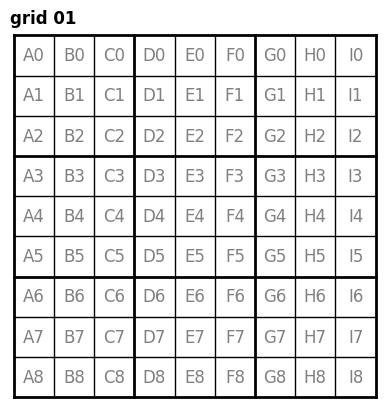

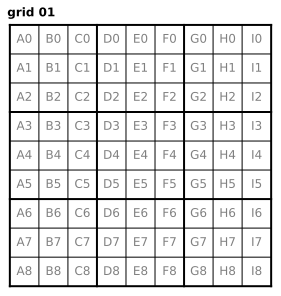

In [280]:
display(Image(figure_data(grid, header, "png")))
SVG(figure_data(grid, header, "svg"))

In [281]:
def char_value(x):
    return int(x) if x.isdigit() else 0

class Sudoku:

    def __init__(self, grid, name=None):
        self.grid = grid
        self.name = name if name is not None else "Unnamed Sudoku"
        self._svg_data = None

    @classmethod
    def from_str(cls, grid, name):
        grid = [[char_value(x) for x in line.strip()] for line in grid]
        return cls(grid, name)

    def __str__(self):
        return f'{self.name}:\n{self.txt()}'

    def _repr_html_(self):
        return f"<style>{css}</style>\n<h3>{self.name}</h3>\n{html_grid(self.as_symbols())}"


    def copy(self):
        grid = [line.copy() for line in self.grid]
        return type(self)(grid, self.name)

    def as_symbols(self, symbols=" 123456789"):
        return [[symbols[x] for x in line] for line in self.grid]

    def txt(self):
        return '\n'.join(map(' '.join, self.as_symbols("_123456789")))

    def _repr_svg_(self):
        return self.svg

    @property
    def svg(self):
        if self._svg_data is None:
            self._svg_data = figure_data(self.as_symbols(), self.name, 'svg')
        return self._svg_data



In [282]:
with open('/tmp/sudoku.txt') as f:
    name = f.readline().strip()
    grid = [f.readline() for _ in range(9)]
    sudoku = Sudoku.from_str(grid, name)

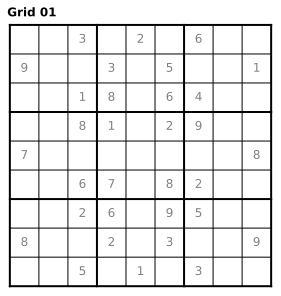

In [307]:
sudoku

Grid 01:
_ _ 3 _ 2 _ 6 _ _
9 _ _ 3 _ 5 _ _ 1
_ _ 1 8 _ 6 4 _ _
_ _ 8 1 _ 2 9 _ _
7 _ _ _ _ _ _ _ 8
_ _ 6 7 _ 8 2 _ _
_ _ 2 6 _ 9 5 _ _
8 _ _ 2 _ 3 _ _ 9
_ _ 5 _ 1 _ 3 _ _


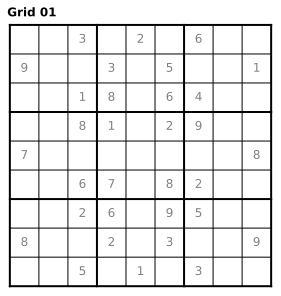

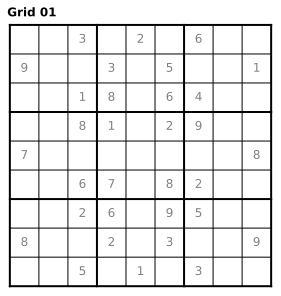

In [284]:
from IPython.display import SVG

print(sudoku)
display(sudoku)
display(SVG(sudoku.svg))


In [ ]:
def drop_comment(file):
    while True:
        try:
            line = next(file).strip()
        except EOFError:
            return
        if not line.startswith("#"):
            yield line

In [108]:
if dowload_large:
    with open('data/puzzles2_17_clue', 'r') as file:
        line = next(drop_comment(file))
        grid = [[int(ch) if ch.isdigit() else 0 for ch in line[i: i+9]] for i in range(0,81,9)]
        sudoku = Sudoku(grid)
    sudoku

## Hogyan fogalmazható meg a feladat a matek eszközeivel?

Hf. Nézzünk utána a `scipy.optimize.milp` függvénynek, ill. a `picosat` python csomagnak. 

# Ha maradna idő

## Feladatok előadásról

### Ismétlődések törlése


Egy adott sztringből távolítsuk el az egymás mellett álló ismétlődő karatereket.

Példa:
```
"kukkkuuuurrrriiiikuuuuuuuu" -> "kukuriku".
```

(Ez már volt korábban. Most keressünk elegánsabb megoldást, pl. az `itertools` könyvtár függvényeinek segítségével.)


In [ ]:

def remove_consecutive_duplicates(string):
    pass


### Számolás polinomokkal

Írjunk egy `Polynomial` osztályt, ahol a polinomot tároljuk el, mint az együtthatóinak listáját.

Implementáljuk két ilyen polinom összeadását (azaz írjuk meg az `__add__`, valamint a `__repr__`  metódust, hogy lássuk, mi egy ilyen egyed ,,tartalma'').

Egy polinom függvény is. Implementáljuk a `__call__` metódust is, ami kiértékeli a polinomot egy adott pontban!


In [410]:
from itertools import dropwhile
from fractions import Fraction


In [428]:
def format_term(k, coeff, fmt="x^{k}"):
    sep = "-" if coeff < 0 else "+"
    coeff = abs(coeff)
    c = f"{coeff}" if coeff != 1 else ""
    match k:
        case 0:
            x = ""
            c = f"{coeff}"
        case 1:
            x = "x"
        case _:
            x = fmt.format(k=k)
    return f"{c}{x}", sep

class Polynomial:
    def __init__(self, *coefficients):
        self.coeff = tuple(dropwhile(lambda x: x==0, coefficients))[::-1]

    def degree(self):
        return len(self.coeff)-1 if self.coeff else 0

    def __eq__(self, other):
        return isinstance(other, type(self)) and self.coeff == other.coeff

    def __add__(self, other):

        coeff_a = self.coeff
        coeff_b = other.coeff

        if len(coeff_a) < len(coeff_b):
            coeff_a, coeff_b = coeff_b, coeff_a

        coeff = list(coeff_a)

        for i, c in enumerate(coeff_b):
            coeff[i] += c

        return Polynomial(*reversed(coeff))

    def __sub__(self, other):
        return self+(-1)*other

    def __mul__(self, other):
        coeff = [0]*(len(self.coeff)+len(other.coeff)-1)
        for i, ca in enumerate(self.coeff):
            for j, cb in enumerate(other.coeff):
                coeff[i+j] += ca*cb

        return Polynomial(*reversed(coeff))

    def __rmul__(self, c):
        coeff = [c0*c for c0 in self.coeff]
        return Polynomial(*reversed(coeff))

    def leading_coeff(self):
        return self.coeff[-1] if self.coeff else 0

    def __divmod__(self, other):
        if not isinstance(other, type(self)):
            raise TypeError

        m = Polynomial()
        r = self
        main_coeff = other.leading_coeff()
        other_dg = other.degree()

        while r.degree() >= other_dg:
            c = r.leading_coeff()/main_coeff
            m += c*monomial(r.degree()-other_dg)
            r = self-m*other
        return m, r

    def __mod__(self, other):
        return divmod(self, other)[1]

    def __floordiv__(self, other):
        return divmod(self, other)[0]

    def __call__(self, x):
        value = 0
        for c in reversed(self.coeff):
            value *= x
            value += c
        return value

    def as_token_list(self, formatter, fmt):
        coeffs = [(k, coeff) for k, coeff in enumerate(self.coeff) if coeff != 0]
        if len(coeffs) == 0:
            coeffs = [(0, 0)]
        tokens = [token for k, coeff in coeffs for token in format_term(k, coeff, fmt)]
        if tokens[-1] == "+":
            tokens.pop()
        tokens.reverse()
        return tokens

    def __str__(self):
        return ''.join(self.as_token_list(format_term, "x^{k}"))

    def __repr__(self):
        return f"{type(self).__name__}({', '.join(map(str, reversed(self.coeff)))})"

    def _repr_latex_(self):
        formula = ''.join(self.as_token_list(format_term, "x^{{{k}}}"))
        return f"$x\mapsto {formula}$"


def monomial(degree, unit=1):
    coeff = [unit]+[0]*degree
    return Polynomial(*coeff)

Néhány példa:

In [635]:
p = Polynomial(-1, -0.0, -3)    # -> x^2 - 3
q = Polynomial(2, 0, -1, 1)  # -> 2x^3 + 3x + 1
display(p)
display(q)
display(p*q)
display(2*p)
print(str(q))
## p**2

Polynomial(-1, -0.0, -3)

Polynomial(2, 0, -1, 1)

Polynomial(-2, 0.0, -5.0, -1.0, 3.0, -3)

Polynomial(-2, -0.0, -6)

2x^3-x+1


In [411]:
p = Fraction(1,1)*p
q = Fraction(1,1)*q

m, r = divmod(q, p)
display(m)
display(r)
display(p)
display(q)
display(m*p)

Polynomial(-2, 0)

Polynomial(-7, 1)

Polynomial(-1, 0, -3)

Polynomial(2, 0, -1, 1)

Polynomial(2, 0, 6, 0)

#### Korábbi feladat

Írjunk egy függvényt, ami kiszámolja az első $n$ természetes szám $p$-ik hatványösszegét.

pl. `p = 0`-ra

```Python
def f0(n):
    return n
```

jó, mert $k^0=1$ ha $k=1,\dots,n$ és ezek összege pont $n$.

Ha `p = 1`, akkor

```Python
def f1(n):
    return n*(n+1)//2
```

jó, mert $\sum_{k=1}^n k = n(n+1)/2$.

Még `p = 2`-t is tanultuk

```Python
def f2(n):
    return n*(n+1)*(2*n+1)//6
```

Általános $p$-re tudunk-e ilyen függvényt írni?

In [569]:
def mk_power_sum(p):
    def f(n):
        total = 0
        for k in range(1, n+1):
            total += k**p
        return total

    f.__doc__ = f"""
        {p}-ik hatványok összegét számolja
        """

    return f

In [570]:
f2_slow = mk_power_sum(2)

In [571]:
f2_slow?

Signature: f2_slow(n)
Docstring: 2-ik hatványok összegét számolja
File:      /tmp/ipykernel_84317/3344454091.py
Type:      function

In [572]:
[f2_slow(i) for i in range(0, 10)]

[0, 1, 5, 14, 30, 55, 91, 140, 204, 285]

In [573]:
def f2_fast(n):
    return n*(n+1)*(2*n+1)//6

In [574]:
%timeit f2_slow(10_000)
%timeit f2_fast(10_000)

2.04 ms ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
742 ns ± 15.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


### Ötlet

$$
    \sum_{k=r}^n  \binom{k}{r} = \binom{n+1}{r+1}
$$

**Bizonyítás.**
$\{1,2,\dots,n+1\}$-ből válasszunk ki $r+1$ különböző számot.

Összes lehetőség:
$$
\binom{n+1}{r+1}.
$$

Számoljuk meg az eseteket aszerint szétbontva is, hogy legnagyobb kiválasztott szám mivel egyenlő.

Ha a legnagyobb szám $k+1$, akkor a maradék $r$ számot $\{1,2,\dots, k\}$ közül választjuk. Így az esetek száma
$$
    \sum_{k+1=r+1}^{n+1} \binom{k}{r} =  \sum_{k=r}^{n} \binom{k}{r}
$$  
$k+1$ helyett $k$ az összegzési változó

Ugyanez másképp.

$$
\binom{k}{r} = \frac{1}{r!} k(k-1)\cdots(k-r+1) = \frac{1}{r!}p_r(k-r+1),\quad\text{ahol}\quad p_r(x) = x(x+1)\cdots(x+r-1)
$$
és
$$
    \sum_{j=1}^{n-r+1} \frac{1}{r!}p_r(j) = \frac{1}{(r+1)!}p_{r+1}(n+1-(r+1)+1)= \frac{1}{(r+1)!} p_{r+1}(n-r+1)\quad\text{minden $n\geq r$ és $r\geq 0$-ra}
$$

Az összegzés felső határa és $p_{r+1}$ argumentuma ugyanaz, azaz

$$
\sum_{j=0}^{n} p_r(j) = \frac{1}{r+1}p_{r+1}(n)
$$

**Lineáris algebra.**

$$
p_0\equiv 1,\quad p_1(x)=x,\quad p_2(x)=x(x+1),\quad\dots,\quad p_r(x)=x(x+1)\cdots(x+r-1)
$$

bázis a legfeljebb $r$-edfokú polinomok vektorterében.

$$
    x^r = \sum_{i=0}^r a_i p_i(x)
$$
és
$$
    \sum_{k=0}^n k^r = \sum_{k=0}^n \sum_{i=0}^r a_i p_i(k) =  \sum_{i=0}^r a_i  \sum_{k=0}^n p_i(k) = \sum_{i=0}^r \frac{a_i}{r+1}  p_{i+1}(n)
$$


### Összefoglalva



- Egy polinomot az együtthatókkal ábrázolhatunk.
- Kellene egy függvény, ami a természetes $1, x, x^2,\dots$ bázisban felírt polinomot a $p_0,p_1,\dots$ bázisban ír fel.
- $p_0, p_1, \dots,$ bázisban az összegzés könnyű, lényegében arrébb kell tolni az együtthatókat.
- A $p_0,p_1,\dots$ bázisban felírt polinomot vagy visszaszámoljuk a természetes bázisba, vagy megírjuk a függvényt, ami kiértékeli a függvényt egy adott pontban.

Vegyük észre, hogy $p_0$ azonosan 1, $p_1(0)=0$, $p_2(0)=p_2(-1)=0$, stb.

Ha $f=\sum_i a_i p_i$, akkor
$$
    f(0) = \sum_i a_i p(0) = a_0, \quad f(-1) = a_0 p_0(-1) + a_1 p_1(-1),\quad f(-k) = a_0 p_0(-k) + a_1 p_1(-k) + \cdots + a_k p_k(-k).
$$
amiből

$$
\begin{align*}
    a_0 & = f(0)\\
    a_1 & = \frac{f(-1) - a_0 p_0(-1)}{p_1(-1)}\\
    \vdots\\
    a_k & = \frac{f(-k) - \sum_{j=0}^{k-1} a_j p_j(-k)}{p_{k}(-k)}\\
    \vdots
\end{align*}
$$  
Kihasználhatjuk még, hogy
$$
p_k(-k)=(-k)(-k+1)\cdots(-k+(k-1))=(-1)^k k!.
$$

In [503]:
def basis():
    i = 0
    p = Polynomial(1)
    while True:
        yield p
        p *= Polynomial(1,i)
        i += 1


In [504]:
from itertools import islice

$$
p_k(-k)=(-k)(-k+1)\cdots(-k+(k-1))=(-1)^k k!.
$$
ellenőrzése. 


In [517]:
for i, p in zip(range(5), basis()):
    display(p)
    print(f"{i=}, {p(-i)=}")
    print("-"*20)

Polynomial(1)

i=0, p(-i)=1
--------------------


Polynomial(1, 0)

i=1, p(-i)=-1
--------------------


Polynomial(1, 1, 0)

i=2, p(-i)=2
--------------------


Polynomial(1, 3, 2, 0)

i=3, p(-i)=-6
--------------------


Polynomial(1, 6, 11, 6, 0)

i=4, p(-i)=24
--------------------


In [653]:
from typing import Callable

def mk_fast_polynomial_sum(p: Polynomial) -> Polynomial:
    """return a polynomial q such that q(n)=sum_{k=1}^n p(k)"""
    q = Polynomial()
    q0 = Polynomial()

    it = iter(basis())
    i = 0

    while q0 != p:
        pi = next(it)
        if i > 0:
            q += (coeff/i)*pi
        coeff = ((p(-i) - q0(-i))/pi(-i))
        q0 += coeff*pi
        i += 1

    q += (coeff/i)*next(it)
    return q

def mk_fast_power_sum(k:int) -> Callable[[int], int]:
    coeff = mk_fast_polynomial_sum(monomial(k, unit=Fraction(1,1))).coeff
    f = math.lcm(*[c.denominator for c in coeff])
    p = Polynomial(*[int(c*f) for c in reversed(coeff)])
    def fun(x: int) -> int:
        return p(x)//f 

    fun.__doc__ = f"computes sum_{{k=1}}^n x^{k}"
    return fun


#### Gyors ellenőrzés.

In [654]:
%%ipytest

def test_fast_power_sum():
    for i in range(1, 4):
        f = mk_fast_power_sum(i)
        g = mk_power_sum(i)
        for n in range(1000):
            assert f(n) == g(n)

.                                                                                            [100%]
1 passed in 0.31s


In [671]:
f2 = mk_fast_polynomial_sum(monomial(2, Fraction(1,1)))
f2a = mk_fast_power_sum(2)

In [670]:
%timeit f2_slow(10_000)
%timeit f2(10_000)
%timeit f2a(10_000)
%timeit f2_fast(10_000)

2.09 ms ± 25.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.43 µs ± 181 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.04 µs ± 12.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
747 ns ± 15.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Törtekkel számolni kicsit lassabb!

Hogyan emlékszik `f2a` a kiszámolt `p` és `f` értékre. A `__closure__` nevű attribútum tárolja. 

In [ ]:
print(f"{f2.__dict__}")
for cell in f2a.__closure__:
    print(cell.cell_contents)


{'coeff': (Fraction(0, 1), Fraction(1, 6), Fraction(1, 2), Fraction(1, 3))}
6
2x^3+3x^2+x


In [674]:
f2a = mk_fast_power_sum(2)
print(f"{f2a.__closure__[0].cell_contents=}, {f2a(2)=}")
f2a.__closure__[0].cell_contents = 3
print(f"{f2a.__closure__[0].cell_contents=}, {f2a(2)=}")

f2a.__closure__[0].cell_contents=6, f2a(2)=5
f2a.__closure__[0].cell_contents=3, f2a(2)=10


In [656]:
help(mk_fast_power_sum(2))

Help on function fun in module __main__:

fun(x: int) -> int
    computes sum_{k=1}^n x^2



In [657]:
[mk_fast_power_sum(2)(i) for i in range(5)]

[0, 1, 5, 14, 30]

In [658]:
mk_fast_polynomial_sum(monomial(8))

Polynomial(0.1111111111111111, 0.5, 0.6666666666666643, 0.0, -0.46666666666715173, 0.0, 0.22222222222444543, 0.0, -0.03333333333284827, 0.0)

Ugyanez a polinom racionális együtthatókkal

In [659]:
mk_fast_polynomial_sum(monomial(8, unit=Fraction(1, 1)))

Polynomial(1/9, 1/2, 2/3, 0, -7/15, 0, 2/9, 0, -1/30, 0)

In [660]:
q = mk_fast_polynomial_sum(monomial(4, Fraction(1,1)))
display(q)
display(30*q)

Polynomial(1/5, 1/2, 1/3, 0, -1/30, 0)

Polynomial(6, 15, 10, 0, -1, 0)

Az első néhány hatványösszeget számoló polinom:

In [676]:
for k in range(10):
    p_k = mk_fast_polynomial_sum(monomial(k, Fraction(1, 1)))
    f = math.lcm(*(c.denominator for c in p_k.coeff))
    print(f"{k=}, {p_k=!s:>50}, {f:>3}*p_k={f*p_k!s:>40}")


k=0, p_k=                                                 x,   1*p_k=                                       x
k=1, p_k=                                       1/2x^2+1/2x,   2*p_k=                                   x^2+x
k=2, p_k=                                1/3x^3+1/2x^2+1/6x,   6*p_k=                             2x^3+3x^2+x
k=3, p_k=                              1/4x^4+1/2x^3+1/4x^2,   4*p_k=                            x^4+2x^3+x^2
k=4, p_k=                        1/5x^5+1/2x^4+1/3x^3-1/30x,  30*p_k=                      6x^5+15x^4+10x^3-x
k=5, p_k=                     1/6x^6+1/2x^5+5/12x^4-1/12x^2,  12*p_k=                      2x^6+6x^5+5x^4-x^2
k=6, p_k=                 1/7x^7+1/2x^6+1/2x^5-1/6x^3+1/42x,  42*p_k=                 6x^7+21x^6+21x^5-7x^3+x
k=7, p_k=             1/8x^8+1/2x^7+7/12x^6-7/24x^4+1/12x^2,  24*p_k=              3x^8+12x^7+14x^6-7x^4+2x^2
k=8, p_k=         1/9x^9+1/2x^8+2/3x^7-7/15x^5+2/9x^3-1/30x,  90*p_k=        10x^9+45x^8+60x^7-42x^5+20x^3-3x
k=9, p_k= 

Igaz-e, hogy a gyökök racionálisak?

$\sum_{i=0}^n i^k = P_{k+1}(n)$

$k=0,1,2,3$ esetén igen.

$$
\begin{aligned}
    x^2+x &= x(x+1)\\
    2x^3+3x^2+x &= x(x+1)(2x+1)\\
    x^4+2x^3+x^2&= x^2(x+1)^2
\end{aligned}
$$


In [662]:
p_5 = mk_fast_polynomial_sum(monomial(4, unit=Fraction(1, 1)))

print(f"{p_5(0)=!s}, {p_5(-1)=!s}, {p_5(Fraction(-1, 2))=!s}, {p_5.degree()=}")

p_5(0)=0, p_5(-1)=0, p_5(Fraction(-1, 2))=0, p_5.degree()=5


Három gyököt találtunk. Legyen $q=x(x+1)(2x+1)$. Ekkor $q$ gyökei pont  a megtalált gyökök. 

In [663]:
q = monomial(1)*Polynomial(1,1)*Polynomial(2,1)
display(q)
print(f"{q(0)=!s}, {q(-1)=!s}, {q(Fraction(-1, 2))=!s}")

Polynomial(2, 3, 1, 0)

q(0)=0, q(-1)=0, q(Fraction(-1, 2))=0


In [664]:
p, r = divmod(30*p_5, q)
print(f"{p=!s}, {r=!s}")

p=3x^2+3x-1, r=0


Gyökök:
$$
    x_{1,2}=\frac{-3\pm\sqrt{3^2-4\cdot 3\cdot(-1)}}{2\cdot3}=\frac12\left(-1\pm\sqrt{\frac7{3}}\right)
$$

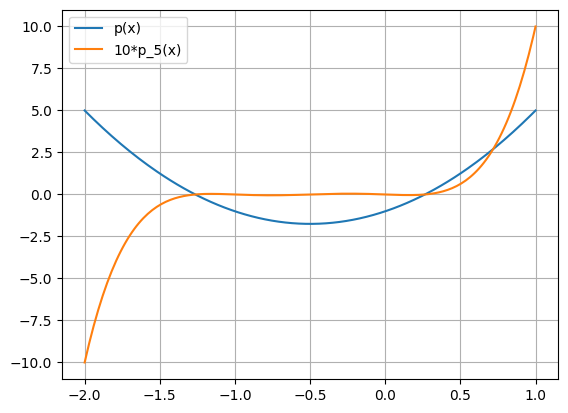

In [665]:
xs = np.linspace(-2, 1, 201)
plt.plot(xs, [p(x) for x in xs], label="p(x)")
plt.plot(xs, [10*p_5(x) for x in xs], label="10*p_5(x)")
plt.legend()
plt.grid()
plt.show()

# Egy gráfelméleti algoritmus

## Feladat

Adott egy `n` csúcsú irányítatlan gráf az élek listájával. A gráf csúcsait `0`-tól `n-1`-ig címkéztük meg, az éleket pedig a végpontokkal.

Emellett adott egy kiindulási pont és egy végpont. Azt szeretnénk eldönteni, hogy el lehet-e jutni a kiindulási pontból a végpontba a gráf éleit használva.

Gondolhatunk arra, hogy a gráf egy úthálózatot ír le és a kérdés az, hogy el tudunk-e jutni `A`-ból `B`-be.

Pl. `n = 3`, élek `edges = [[0,1], [1,2], [2,0]]`, `A =  0`, `B = 2`.

Gráfok megjelenítésére egy hasznos könyvtár a `graphviz`.

In [ ]:
import importlib
if importlib.util.find_spec('graphviz') is None:
    ! pip install graphviz
import graphviz

In [ ]:
edges = [[0,1], [1,2], [2,0]]
g0 = graphviz.Graph()

g0.edges([(str(a), str(b)) for a, b in edges])
g0

A gráf összefüggő, tetszőleges `A`, `B` esetén a válasz: `True`

In [ ]:
n = 6
edges = [[0,1],[0,2],[3,5],[5,4],[4,3]]
A = 0
B = 5

g1 = graphviz.Graph()
g1.edges([(str(a), str(b)) for a, b in edges])
g1

Nincs út 0 és 5 között. A válasz: `False`

Összefüggőségi komponenseket szeretnénk számolni.



## Ötlet.

Az él nélküli gráfból indulunk ki. Itt egy elemű komponensek vannak.

Minden komponensből válasszunk egy reprezentáns és minden $i$ pontra feljegyezzük, melyik komponensben van.




In [ ]:
def show_graph(roots, direction = 'LR'):
    g = graphviz.Digraph(graph_attr={'rankdir': direction})
    g.edges((str(i), str(r)) for i, r in enumerate(roots))
    return g

In [ ]:
n = 5
roots = [i for i in range(n)]
display(show_graph(roots, 'TD'))

ha behúzzuk a $(0, 1)$ élet, akkor $0$ és $1$ azonos komponensbe kerül. Választhatunk a két összeuniózott komponens reprezentánsa között, legyen pl. 1

In [ ]:
roots[0] = 1
display(show_graph(roots, 'TD'))

Ha most a (0, 2) élet akarjuk behúzni, akkor nem állíthatjuk át `roots[0]`. Meg kell keresnünk `0` komponensének reprezentását, ez 1 és vagy `roots[1]`-et állítjuk 2 -re, vagy `roots[2]`-t 1-re.

In [ ]:
def find(roots, a):
    while a != roots[a]:
        a = roots[a]
    return a

In [ ]:
find(roots, 0), find(roots, 2)

In [ ]:
def union(roots, a, b):
    ra = find(roots, a)
    rb = find(roots, b)
    roots[ra] = rb

In [ ]:
union(roots, 0, 2)
print(f"After union(0, 2) {roots=}")
display(show_graph(roots))

union(roots, 3, 4)
print(f"After union(3, 4) {roots=}")
print(roots)
display(show_graph(roots))

union(roots, 3, 2)
print(f"After union(3, 2) {roots=}")
print(roots)
display(show_graph(roots))

Ezután az a kérdés, hogy el lehet-e jutni `A`-ból, `B`-be könnyen eldönthető. Ha `A` és `B` azonos komponensben van, akkor `A` és `B` között megy út az eredeti gráfban, különben nem.

1. példa
`n = 3`, élek `edges = [[0,1], [1,2], [2,0]]`, `A =  0`, `B = 2`.

In [ ]:
def show_edges(edges, direction='LR'):
    g = graphviz.Graph(graph_attr={'rankdir': direction})
    g.edges([(str(a), str(b)) for a, b in edges])
    return g

In [ ]:
n = 3
edges = [[0,1], [1,2], [2,0]]
A =  0
B = 2

display(show_edges(edges, 'TD'))
print(f"Eredeti gráf")
print("="*50)

roots = [i for i in range(n)]
for a, b in edges:
    union(roots, a, b)

display(show_graph(roots))
print(f"{A=} és {B=} {'azonos' if find(roots, A)==find(roots, B) else 'különböző'} komponensben van")

2. példa

In [ ]:
n = 6
edges = [[0,1],[0,2],[3,5],[5,4],[4,3]]
A = 0
B = 5

display(show_edges(edges))
print(f"Eredeti gráf")
print("="*50)

roots = [i for i in range(n)]
for a, b in edges:
    union(roots, a, b)

display(show_graph(roots))
print(f"{A=} és {B=} {'azonos' if find(roots, A)==find(roots, B) else 'különböző'} komponensben van")


Látszik, hogy először létre kell hoznunk a `roots` tömböt, majd utána ezzel kell számolnunk.

Célszerű egy osztályt léterhozni:

In [ ]:
class UnionFind:
    def __init__(self, n):
        self.roots = [i for i in range(n)]

    def find(self, a):
        while a != self.roots[a]:
            a = self.roots[a]
        return a

    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra != rb:
            self.roots[ra] = rb
        return self

    def show(self, *args, **kwargs):
        display(show_graph(self.roots, *args, **kwargs))

Mi történik, ha nagyobb gráfunk van?

In [ ]:
n = 10
edges = [(0,i+1) for i in range(n-1)]
display(show_edges(edges, 'TD'))

uf = UnionFind(n)
for a, b in edges:
    uf.union(a, b)

uf.show()

Valahányszor behúzzuk a $(0, i)$ élet, meg kell keresni $0$ reprezentánsát. $k$ él behúzása után $k$-lépéssel találjuk meg. Ha 10 helyett 10_000 méretű a gráf ez nem fog működni.

### Javítási lehetőségek.

- Amikor megkeressük $i$ reprezentánsát végig megyünk a reprezentánshoz vezető úton. Minden meglátogatott csúcsra ismerté válik a reprezentáns értéke. Ezt beírhatjuk a `roots` tömbe. (path compression)

- A nagyobb komponensbe kössük be a kisebbet és ne fordítva. Ehhez  a ,,méretet'' nyilván kell tartani.

In [ ]:
def find_better(roots, a):
    ra = roots[a]
    if a != ra:
        ra = find_better(roots, ra)
        roots[a] = ra
    return ra

def find_better_without_recursion(roots, a):
    stack = []

    ra = roots[a]
    while a != ra:
        stack.append(a)
        a = ra
        ra = roots[a]

    while stack:
        roots[stack.pop()] = ra

    return ra


def union_sizes(roots, sizes, a, b):
    ra = find_better(roots, a)
    rb = find_better(roots, b)
    if ra != rb:
        if sizes[ra] < sizes[rb]:
            ra, rb = rb, ra
        roots[rb] = ra
        sizes[ra] += sizes[rb]

def union_ranks(roots, ranks, a, b):
    ra = find_better(roots, a)
    rb = find_better(roots, b)
    if ra != rb:
        if ranks[ra] < ranks[rb]:
            ra, rb = rb, ra
        roots[rb] = ra
        if ranks[ra] == ranks[rb]:
            ranks[ra] += 1

In [ ]:
n = 10
edges = [(0, i) for i in range(1, n)]
display(show_edges(edges, 'TD'))

roots = [i for i in range(n)]

for a, b in edges:
    ra = find_better(roots, a)
    rb = find_better(roots, b)
    roots[ra] = rb

display(show_graph(roots, 'LR'))


In [ ]:
n = 10
edges = [(0, i) for i in range(1, n)]
display(show_edges(edges, 'TD'))

roots = [i for i in range(n)]

for a, b in edges:
    ra = find_better(roots, a)
    rb = find_better(roots, b)
    roots[rb] = ra

display(show_graph(roots, 'TD'))


In [ ]:
n = 10
edges = [(0, i) for i in range(1, n)]
display(show_edges(edges, 'TD'))

roots = [i for i in range(n)]
sizes = [1]*n

for a, b in edges:
    union_sizes(roots, sizes, a, b)

display(show_graph(roots, 'TD'))


In [ ]:
n = 10
edges = [(0, i) for i in range(1, n)]
display(show_edges(edges, 'TD'))

roots = [i for i in range(n)]
ranks = [0]*n

for a, b in edges:
    union_ranks(roots, ranks, a, b)

display(show_graph(roots, 'TD'))


### Szokásos implementáció

In [ ]:
class UnionFind:
    def __init__(self, n):
        self.roots = [i for i in range(n)]
        self.sizes = [1]*n

    def find(self, a):
        ra = self.roots[a]
        if a != ra:
            ra = self.find( ra)
            self.roots[a] = ra
        return ra

    def union(self, a, b):
        ra = self.find(a)
        rb = self.find(b)
        if ra != rb:
            if self.sizes[ra] < self.sizes[rb]:
                ra, rb = rb, ra
            self.roots[rb] = ra
            self.sizes[ra] += self.sizes[rb]


In [ ]:
uf = UnionFind(10)
print(uf)
uf.union(1, 2)
print(uf)
uf.union(5, 9)
uf.union(6, 7)
print(uf)

uf

`__str__` és `__repr__` metódusok

In [ ]:
def as_set(seq):
    return f"{{{', '.join(map(str, seq))}}}"

def uf_str(self):
    components = {}
    for a in range(len(self.roots)):
        ra = self.find(a)
        if ra not in components:
            components[ra] = []
        components[ra].append(a)
    return f"{{{ ', '.join(map(as_set, components.values()))}}}"

def uf_repr(self):
    return f"{type(self).__name__}({len(self.roots)})"

# Így is lehet:
UnionFind.__str__ = uf_str
UnionFind.__repr__ = uf_repr

In [ ]:
uf = UnionFind(10)
print(uf)
uf.union(1, 2)
print(uf)
uf.union(5, 9)
uf.union(6, 7)
print(uf)

uf

### További kérdések

- Tegyük fel, hogy a komponensek száma érdekel minket. Hogyan oldanánk, meg, hogy konstans idő alatt megkaphassuk.
- Tegyük fel, hogy a legnagyobb komponens méretet érdekel minket. Hogyan oldanánk, meg, hogy konstans idő alatt megkaphassuk.
- Hogyan ellenőriznénk, hogy két partíció azonos?

# Faktoriális értékének közelítése

Mekkora $n!$, ha $n$ nagy?

Ötlet:
$$
    \log n! = \sum_{k=1}^n \log k \approx \int_1^{?} \log x dx = \left[ x(\log x-1)\right]_{x=1}^{x=?}
$$

In [ ]:
import matplotlib.pyplot as plt
import math

def subdivision(a, b, n):
    d = (b-a)/n
    return [a+i*d for i in range(n+1)]

def add_function_curve(f, a, b, n=100):
    xs = subdivision(a, b, n)
    fxs = [f(x) for x in  xs]
    plt.plot(xs, fxs, "r-")

## Téglalap közelítés

In [ ]:
k_values = [k for k in range(1, 11)]
for k in k_values:
    plt.fill_between([k+i for k in k_values for i in range(2)], [math.log(k) for k in k_values for i in range(2)], color='lightblue')

add_function_curve(math.log, 1, 11)


A hiba:

In [ ]:
def primitive_function(x):
    return x*(math.log(x)-1)

def rectangle_error(k):
    return primitive_function(k+1)-primitive_function(k)-math.log(k)

def cummulative_error(n, error_fun=rectangle_error):
    return sum(error_fun(k) for k in range(1, n+1))

In [ ]:
for n in [10, 100, 1000]:
    print(f"{n=}, {cummulative_error(n)=}")

### Javítás, trapéz összeg közelítés

Téglalapok helyett minden egység intervallumon a beírt trapézt  használjuk.

In [ ]:
k_values = [k for k in range(1, 11)]
for k in k_values:
    plt.fill_between(k_values, [math.log(k) for k in k_values], color='lightblue')

add_function_curve(math.log, 1, 10)


In [ ]:
def error_fun(x):
    k, t = divmod(x, 1)
    return math.log(x) - ((1-t)*math.log(k) + t*math.log(k+1))

xs = subdivision(1, 10, 100)
plt.fill_between(xs, [error_fun(x) for x in xs], color='lightblue')
add_function_curve(error_fun, 1, 10, 500)


In [ ]:
def modified_error_fun(x):
    k = x//1
    return k*k*error_fun(x)

for a in [1, 100, 1000, 10000]:
    b = a+10
    xs = subdivision(a, b, 1000)

    plt.fill_between(xs, [modified_error_fun(x) for x in xs], color='lightblue')
    add_function_curve(modified_error_fun, a, b, 1000)
    plt.show()

In [ ]:
def trapezoid_error(k):
    return primitive_function(k+1)-primitive_function(k)-0.5*(math.log(k)+math.log(k+1))


In [ ]:
for n in [10, 100, 1000]:
    print(f"{n = :>4}, {cummulative_error(n, trapezoid_error) = :.8f}")

## Látszik, hogy a hiba lassan nő. Tudunk-e felső becslést adni rá?

$$
    \int_{k}^{k+1} \log x dx = \int_0^1 \log(k+x) dx
$$

A beírt trapéz területe integrállal

$$
    \int_0^1 x\log(k+1)+(1-x)\log(k) dx
$$

Tudjuk-e becsülni a két integrandus különbségét?
$$
    \log(k+x) - (x\log(k+1)+(1-x)\log(k))
$$

Átalakítás mindkét tagból levonunk $\log(k)$-t:
$$
    \log(k+x) - \log(k) - (x\log(k+1)+(1-x)\log(k) -\log(k)) = \log(1+\tfrac{x}{k}) - x\log(1+\tfrac1k)
$$


In [ ]:
xs = subdivision(0, 1, 100)

for k in range(1, 4):
    plt.fill_between(xs, [math.log(k+x)-math.log(k) for x in xs], [math.log(k+1)*x+math.log(k)*(1-x)-math.log(k) for x in xs], color="blue")

plt.grid()

A logaritmus függvény konkáv, a derivált monoton fogy ($1/x$) és egy beírt húr mindig a végponthoz behúzott érintő egyenesek alatt van.

$$
    \log (1+x)\leq x
$$

ezért
$$
    \log(1+x/k) - x \log(1+1/k)\leq \frac xk - x\log(1+1/k) = x(1/k -\log(1+1/k))
$$

de
$$
    \log(1+1/k) = \log\frac{k+1}{k} = -\log\frac{k}{k+1} = -\log(1-1/(k+1)) \geq \frac1{k+1}
$$

Így

$$
    \log(1+x/k) - x \log(1+1/k)\leq x\left(\frac1k-\frac1{k+1}\right)
$$
és
a $k$. intervallumon elkövetett hiba legfeljebb
$$
    \int_{0}^{1} \log(k+x) - ((1-x)\log(k)+x\log(k+1))dx = \int_0^1 x dx \left(\frac1k -\frac1{k+1}\right)
$$
A hibák összege legfeljebb:
$$
    \frac12 \sum_{k=1}^\infty \frac1k -\frac1{k+1} =\frac12
$$

Összefoglalva:

$$
    \log n! = \int_1^n \log x dx + \frac12 \log n + r_n = n(\log(n) - 1) + 1 + \frac12 \log (n) + r_n
$$
ahol $r_n$ a közelítés hibája az első $n$ intervallumon
$$
    r_n = \sum_{k=1}^n \int_0^1 \log(1+x/k)-x\log(1+1/k)dx \leq 1/2
$$
$(r_n)$ monoton nő, ezért létezik limesze.

Visszaírva faktoriálisra:

$$
    n! = \sqrt{n}\left(\frac{n}{e}\right)^n c_n
$$
ahol $c_n=e^{1+r_n}\leq e^{3/2}$

Analízisben a Wallis formula következményeként szerepel

$$
\lim c_n = \sqrt{2\pi}
$$

Ez a nevezetes **Stirling** formula:
$$
 \frac{n!}{\sqrt{2\pi n}\left(\frac{n}{e}\right)^n} \to 1
$$


### Wallis formula középiskolai eszközökkel


Középiskolai tudást használva is kiszámíthatnánk a limeszt. Ehhez a
$$
    I_n = \int_{0}^{\pi/2} \cos^n(x) dx
$$
sorozatot kellen vizsgálni. Parciálisan integrálva:
$$
    I_{n+2} = \int_{0}^{\pi/2} (1-\sin^2x)\cos^n(x) dx
    = I_n - \int_{0}^{\pi/2} \sin^2(x)\cos^n(x) dx
$$
ahol
$$
\begin{aligned}
-\int_{0}^{\pi/2} \sin^2(x)\cos^n(x) dx
& =
\frac1{n+1} \int_{0}^{\pi/2} \sin(x)(\cos^{n+1}(x))' dx
\\
&=
\frac{1}{n+1}\left[\sin(x)\cos^{n+1}(x)\right]_{x=0}^{x=\pi/2}-\frac{1}{n+1}\int_0^{\pi/2}\cos^{n+2}(x)dx
\\
&= -\frac{1}{n+1} I_{n+2}
\end{aligned}
$$

**Összefoglalva**:

$$
    I_{n+2} = \int_{0}^{\pi/2} (1-\sin^2x)\cos^n(x) dx
    = I_n - \frac{1}{n+1}I_{n+2} = \frac{n+1}{n+2} I_n
$$

Ha $n=2k$ páros, akkor
$$
    I_{2k} = \frac{2k-1}{2k} I_{2k-2} = \frac{(2k-1)(2k-3)}{2k(2k-2)} I_{2k-4} =\cdots=\frac{(2k-1)!!}{2^k k!}I_0=\frac{1}{2^{2k}}\binom{2k}{k}\frac{\pi}2
$$
Ha $n=2k+1$ páratlan, akkor
$$
    I_{2k+1} = \frac{2k}{2k-1} I_{2k-3} = \frac{(2k)(2k-2)}{(2k+1)(2k-1)} I_{2k-3} =\cdots=\frac{2^k k!}{(2k+1)!!}I_1=\frac{2^{2k}}{(2k+1)\binom{2k}{k}}=\frac{2^{2(k+1)}}{2(k+1)\binom{2(k+1)}{k+1}}
$$
Mivel $(I_n)$ monoton fogyó:
$$
    I_{2k-1}=\frac{2^{2k}}{2k\binom{2k}{k}}  > I_{2k} = \frac{1}{2^{2k}}\binom{2k}{k}\frac{\pi}2  > I_{2k+1}= \frac{2^k k!}{(2k+1)!!}I_1=\frac{2^{2k}}{(2k+1)\binom{2k}{k}}
$$
Átrendezés után
$$
\frac{1}{2k\pi/2} < \left(\frac{1}{2^{2k}}\binom{2k}{k}\right)^2 < \frac{1}{(2k+1)\pi/2}
$$
és
$$
    \lim_{n\to\infty}\sqrt{n} \frac{1}{2^{2n}}\binom{2n}{n} = \frac{1}{\sqrt{\pi}}
$$

Másfelől a faktoriális közelítését használva:
$$
    \sqrt{n}\frac1{2^{2n}}\binom{2n}{n}
    = \sqrt{n} \frac1{2^{2n}} \frac{c_{2n} \sqrt{2n} \left(\frac{2n}{e}\right)^{2n}}{c_n^2 n\left(\frac{n}{e}\right)^{2n}}
    \to \lim_{n\to\infty} \frac{\sqrt{2}c_{2n}}{c_n^2} = \lim_{n\to\infty}\frac{\sqrt{2}}{c_n}=\frac1{\sqrt{\pi}}
$$
amiből $\lim_n c_n =\sqrt{2\pi}$.



# Conway Game of Life


The Game of Life is a cellular automaton created by mathematician John Conway in 1970. The game consists of a board of cells that are either on or off. One creates an initial configuration of these on/off states and observes how it evolves. There are four simple rules to determine the next state of the game board, given the current state:

- **Overpopulation**: if a living cell is surrounded by more than three living cells, it dies.
- **Stasis**: if a living cell is surrounded by two or three living cells, it survives.
- **Underpopulation**: if a living cell is surrounded by fewer than two living cells, it dies.
- **Reproduction**: if a dead cell is surrounded by exactly three cells, it becomes a live cell.


Írjunk egy osztályt a játékhoz, pl. az `__init__` metódus hozzalétre a megadott konfigurációnak megfelelő objektumot. Legyen egy `step` metódus, ami a rendszert a következő állapotába viszi és az `__str__` metódus pedig
valahogy ábrázolja az aktuális állapotot. 

Tegyük fel, hogy a rács amin a rendszer él, egy $n\times n$-es rács, ahol mindkét irányban ciklikusan körbemegyünk,
azaz a csúcsokat modulo $n$ tekintjük.


In [228]:
class ConwayGoL:
    
    def __init__(self, state):
        self.state = list(state)

    def step(self):
        return self

    def __repr__(self):
        return f"{type(self).__name__}({self.state})"

In [229]:
import random

init_state = [] ## ???
conway = ConwayGoL(init_state)

conway.step()


ConwayGoL([])

A játék állapotának leírásához egy $m\times n$ rács minden pontjáról tudni kell, hogy foglalt-e vagy sem.

```python
m, n = 11, 11
state = [[0]*n for _ in range(m)]
```

Véletlenszerű kezdeti állapot:
```python
state = [[random.randint(0,1) for _ in range(n)] for _ in range(m)]
```

In [230]:
def random_state(n, m, p):
    return [[int(random.random()<p) for _ in range(m)] for _ in range(n)]

state = random_state(5, 6, 0.2)
print(state)

[[0, 0, 0, 0, 1, 0], [0, 1, 1, 1, 0, 1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0], [1, 1, 0, 0, 0, 0]]


Szebb megjelenítés?

In [231]:
def as_matrix(lst, n):
    return [lst[i:i+n] for i in range(0, len(lst), n)]

print('\n'.join(''.join(map(str, line)) for line in state))


000010
011101
000000
000100
110000


In [232]:
for symbols in [
    "\u2b1c\u2b1b",
    "·♥",
    "🟡🟥"
    ]:
    print('\n'.join(''.join(symbols[x] for x in line) for line in state))


⬜⬜⬜⬜⬛⬜
⬜⬛⬛⬛⬜⬛
⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬛⬜⬜
⬛⬛⬜⬜⬜⬜
····♥·
·♥♥♥·♥
······
···♥··
♥♥····
🟡🟡🟡🟡🟥🟡
🟡🟥🟥🟥🟡🟥
🟡🟡🟡🟡🟡🟡
🟡🟡🟡🟥🟡🟡
🟥🟥🟡🟡🟡🟡


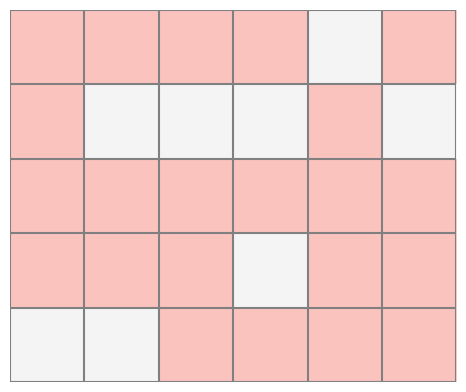

In [233]:
import matplotlib.pyplot as plt 

img = plt.matshow(state, cmap="Pastel1", vmax=1, vmin=0, alpha=0.8)
img.axes.axis("off")
n, m = len(state), len(state[0])
for pos in range(0, n+1):
    img.axes.axhline(y=pos-0.5, color="gray")
for pos in range(0, m+1):
    img.axes.axvline(x=pos-0.5, color="gray")

plt.show()


In [234]:

def cgol_str(self):
    symbols = "\u2b1c\u2b1b"
    return '\n'.join(''.join(symbols[x] for x in line) for line in self.state)

ConwayGoL.__str__ = cgol_str

    

In [235]:
conway = ConwayGoL(state)
print(conway)

⬜⬜⬜⬜⬛⬜
⬜⬛⬛⬛⬜⬛
⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬛⬜⬜
⬛⬛⬜⬜⬜⬜


A `step` metódushoz ki kellene számolni egy adott csúcs foglalt szomszédainak számát `cnt`. Ha ez kész,
akkor az $i$ csúcs új állapota:

$$
    \text{state}_{t+1}[i]=
    \begin{cases}
    1 &\text{Ha $\text{cnt}[i]\in\{2,3\}$ és $\text{state}_t[i]=1$}\\
    1 &\text{Ha $\text{cnt}[i]\in\{3\}$ és $\text{state}_t[i]=0$}\\
    0 &\text{különben}
    \end{cases}
$$

In [236]:
def newstate(state, count):
    return [int((c==3)|((c==2) & (s==1))) for s, c in  zip(state, count)]

In [241]:
import ipytest
ipytest.autoconfig()

In [242]:
%%ipytest

def test_newstate():
    res = [0]*9
    res[2] = 1
    res[3] = 1
    assert newstate([1]*9, list(range(9))) == res
    res = [0]*9
    res[3] = 1    
    assert newstate([0]*9, list(range(9))) == res


.                                                                                            [100%]
1 passed in 0.01s


In [243]:
def count_neighbors(state):
    delta = [(0,-1), (0, 1), (1,-1), (1,0), (1,1), (-1,-1), (-1,0), (-1,1)] 
    m, n = len(state), len(state[0])
    return [ [sum(state[(i+di) % m][(j+dj) % n] for di, dj in delta) for j in range(n)] for i in range(m)]

def cgol_step(self):
    counts = count_neighbors(self.state)
    self.state = [ newstate(line, cnt) for line, cnt in zip(self.state, counts) ]
    return self
    
ConwayGoL.step = cgol_step

In [244]:
@classmethod
def cgol_from_random_state(cls, n, m,  p):
    return cls(random_state(n, m, p))

ConwayGoL.from_random_state=cgol_from_random_state

In [248]:
conway = ConwayGoL.from_random_state(5, 10, 0.2)
print(conway)
print(*count_neighbors(conway.state), sep='\n')

⬜⬜⬛⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬛⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬛⬜⬜⬜⬛⬜⬛⬜
⬜⬜⬜⬛⬜⬛⬜⬛⬜⬛
⬜⬜⬛⬜⬛⬜⬜⬜⬜⬜
[0, 3, 2, 4, 1, 1, 0, 0, 0, 0]
[0, 3, 2, 3, 0, 1, 1, 2, 1, 1]
[1, 2, 2, 3, 2, 2, 2, 3, 2, 2]
[1, 2, 3, 3, 3, 2, 3, 2, 3, 1]
[1, 2, 2, 4, 2, 2, 2, 1, 2, 1]


In [225]:
conway = ConwayGoL.from_random_state(5, 5, 0.25)
print(conway)
print("-"*20)
print(conway.step())

⬜⬜⬜⬜⬛
⬛⬜⬜⬜⬜
⬜⬜⬛⬜⬜
⬜⬜⬛⬜⬜
⬜⬛⬜⬜⬜
--------------------
⬛⬜⬜⬜⬛
⬛⬜⬜⬜⬜
⬜⬛⬛⬜⬜
⬜⬛⬛⬜⬜
⬜⬛⬜⬜⬜


Tudunk-e valami animációszerűt készíteni? Jupyter notebook-ban pl. a következő képpen lehet: 

In [222]:
from ipywidgets import Output
from time import sleep


In [249]:

out = Output()
display(out)
conway = ConwayGoL.from_random_state(n=21, m=51, p=0.2)

for i in range(50):
    out.clear_output(True)
    with out:
        print(f"After {i} steps:\n{conway}")  
    sleep(0.15)
    conway.step()


Output()

## Ugyanez `numpy` tömbbel

In [250]:
import numpy as np

### Random `state`

In [251]:
def random_state_np(m, n, p):
    return np.random.binomial(1, p, size=(m, n)).astype(np.int8)


In [252]:
print(random_state_np(11, 21, 0.2))

[[0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0]
 [0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0]
 [1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0]]


### `__str__` unicode karakterrel

In [253]:

symbols_array = np.array(["\u2b1c", "\u2b1b"])

def str_state_np(state):
    return '\n'.join(map(''.join, symbols_array[state]))

In [254]:
print(str_state_np(random_state(11, 21, 0.2)))

⬜⬜⬛⬛⬛⬜⬜⬜⬛⬛⬛⬜⬛⬜⬛⬜⬜⬜⬜⬜⬜
⬜⬛⬜⬛⬛⬜⬜⬛⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬛⬜⬜⬜⬜⬜⬛⬜⬜⬛⬜⬛⬜⬜⬛⬜⬜⬛
⬛⬜⬜⬜⬜⬛⬛⬜⬜⬜⬜⬜⬜⬜⬛⬛⬜⬜⬜⬜⬜
⬜⬜⬛⬜⬜⬜⬜⬜⬜⬜⬛⬜⬛⬜⬜⬜⬜⬛⬜⬜⬛
⬜⬜⬜⬜⬛⬜⬜⬛⬛⬜⬛⬜⬜⬛⬛⬜⬜⬜⬜⬛⬜
⬜⬛⬜⬜⬛⬛⬜⬜⬜⬜⬜⬜⬛⬜⬜⬜⬛⬛⬜⬛⬜
⬛⬜⬜⬜⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛
⬛⬛⬛⬜⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜⬛⬜⬜
⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜⬜⬜⬜⬜⬜⬛⬛⬜⬜
⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜⬛⬛⬜⬛⬜⬜⬛⬛⬜


### Szomszédszám `pad`-el

In [255]:
def count_neighbors_np(state, mode='wrap'):
    count = np.pad(state, pad_width=((1,1), (1,1)), mode=mode)
    count = count[2:]+ count[1:-1] + count[:-2]
    count = count[:, 2:] + count[:, 1:-1] + count[:,:-2]
    return count-state

In [256]:
state = random_state_np(5, 8, 0.2)
print(str_state_np(state))
print(count_neighbors_np(state))

⬛⬜⬜⬛⬜⬜⬜⬛
⬜⬛⬜⬛⬜⬜⬛⬛
⬜⬜⬜⬜⬜⬜⬛⬜
⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬛⬜⬜⬜⬜⬜
[[3 3 4 2 2 1 3 3]
 [4 1 3 1 2 2 3 4]
 [2 1 2 1 1 2 2 3]
 [0 1 1 1 0 1 1 1]
 [2 2 1 2 1 0 1 2]]


In [257]:
def new_state_np(state):
    count = count_neighbors_np(state)
    return ((count == 3)|((count == 2) & (state==1))).astype(np.int8)

In [258]:
x = np.arange(5)
(x<4)&(x>2)

array([False, False, False,  True, False])

In [259]:
state0 = random_state_np(11, 21, 0.2)
state1 = new_state_np(state0)
print(str_state_np(state0))
print('='*50)
print(str_state_np(state1))

⬜⬜⬛⬛⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜⬜⬜⬛⬜⬜⬜⬜
⬜⬜⬜⬜⬛⬜⬜⬛⬜⬜⬜⬜⬜⬛⬛⬛⬜⬜⬜⬜⬜
⬜⬜⬛⬜⬜⬜⬜⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜⬜
⬜⬛⬜⬜⬛⬛⬜⬜⬜⬜⬜⬛⬜⬜⬛⬜⬛⬛⬜⬜⬜
⬜⬜⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜⬜
⬜⬜⬜⬛⬜⬜⬜⬛⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜⬛⬜⬜
⬛⬛⬜⬛⬜⬜⬛⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬛⬜
⬜⬜⬜⬜⬜⬜⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜⬜⬛⬜⬜⬜⬛⬛⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜
⬜⬜⬜⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬛⬛⬜⬜⬜⬜⬜
⬜⬜⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬛⬛⬜⬜⬜⬜⬜
⬜⬜⬜⬛⬛⬛⬛⬜⬜⬜⬜⬜⬜⬛⬜⬜⬛⬛⬜⬜⬜
⬜⬛⬛⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬛⬜⬜
⬜⬜⬛⬛⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬛⬜⬛⬜⬜
⬜⬛⬜⬛⬜⬜⬛⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜⬜
⬜⬜⬛⬜⬜⬜⬛⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬛⬛⬜
⬜⬜⬛⬜⬜⬜⬛⬛⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬛⬛
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬛⬛⬜⬜⬜


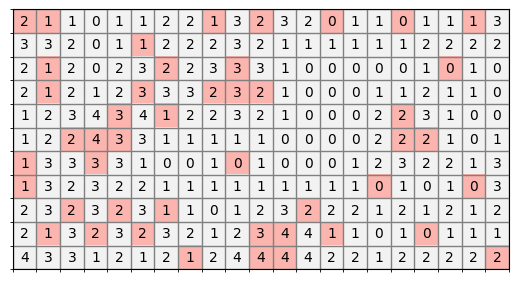

In [260]:
state = random_state_np(11, 21, 0.2)
plt.imshow(state, cmap='Pastel1_r', vmax=1, vmin=0)
plt.xticks(np.arange(state.shape[1]+1)-.5, minor=True)
plt.xticks([])
plt.yticks(np.arange(state.shape[0]+1)-.5, minor=True)
plt.yticks([])
plt.grid(which="minor", color="gray", linestyle='-', linewidth=1)
plt.axis()

for (i, j), cnt in np.ndenumerate(count_neighbors_np(state)):
    plt.text(j, i, str(cnt), ha="center", va="center")
    

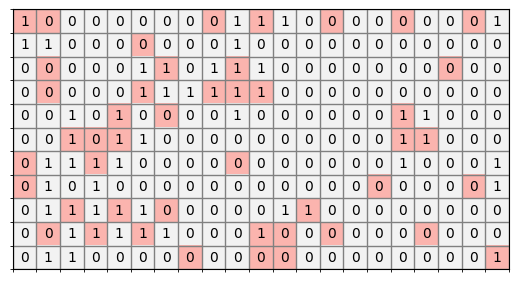

In [261]:
plt.imshow(state, cmap='Pastel1_r', vmax=1, vmin=0)
plt.xticks(np.arange(state.shape[1]+1)-.5, minor=True)
plt.xticks([])
plt.yticks(np.arange(state.shape[0]+1)-.5, minor=True)
plt.yticks([])
plt.grid(which="minor", color="gray", linestyle='-', linewidth=1)
plt.axis()

for (i, j), cnt in np.ndenumerate(new_state_np(state)):
    plt.text(j, i, str(cnt), ha="center", va="center")
    

In [262]:
out = Output()
display(out)
state = random_state_np(n=51, m=21, p=0.2)

for i in range(50):
    out.clear_output(True)
    with out:
        print(f"After {i} steps:\n{str_state_np(state)}")  
    sleep(0.15)
    state = new_state_np(state)


Output()

## Parancssoros script

Ha parancssorból dolgozunk, akkor valami ilyesmit lehetne tenni

In [264]:
%%writefile conway.py

import random


def random_state(m, n, p):
    return [ [ int(random.random()<p) for _ in range(n) ] for _ in range(m) ]

def count_neighbors(state):
    delta = [(0,-1), (0, 1), (1,-1), (1,0), (1,1), (-1,-1), (-1,0), (-1,1)] 
    m, n = len(state), len(state[0])
    return [ [sum(state[(i+di) % m][(j+dj) % n] for di, dj in delta) for j in range(n)] for i in range(m)]

def newstate(state, count):
    return [int((c==3)|((c==2) & (s==1))) for s, c in  zip(state, count)]

class ConwayGoL:
    symbols = "\u2b1c\u2b1b"
    
    def __init__(self, state):
        self.state = list(state)
        
    def step(self):
        counts = count_neighbors(self.state)
        self.state = [ newstate(line, cnt) for line, cnt in zip(self.state, counts) ]
        return self

    
    def __str__(self): 
        symbols = self.symbols
        return '\n'.join(''.join(symbols[x] for x in line) for line in self.state)

    def __repr__(self):
        return f"{type(self).__name__}({self.state})"
    
    @classmethod
    def from_random_state(cls, m, n, p):
        return cls(random_state(m, n, p))

    def is_empty(self):
        return not any(any(line) for line in self.state)


def clear_terminal(n):
    print(f"{chr(27)}[{n+1}A", end="")

def main(m=11, n=25, p=0.2, nsteps=10, clear_screen=clear_terminal):
    from time import sleep
    conway = ConwayGoL.from_random_state(m, n, p)
    for i in range(nsteps+1):
        if i>0:
            clear_screen(m)
        print(f"after {i} step:")
        print(conway)  
        sleep(0.2)
        conway.step()
        if conway.is_empty():
            break
    
if __name__ == "__main__":
    main()
    

Overwriting conway.py


Ha valamit már megírtunk és szeretnénk használni, `import`-tal elérhető. Pl.

### Tudunk-e paramétereket adni a python scriptnek?

Amikor egy python scriptet futtatunk, a parancssor (amivel a futást indítottuk) a `sys` modul `argv` változójában érhető el.

In [ ]:
import sys
sys.argv

In [ ]:
! python -c 'import sys; print(sys.argv)' -alma


Egy nagyon egyszerű megoldás, ha minden opciónak a neve a paraméter amit beállít és egyenlőségjel után az értéke:
pl. n=11 m=25 nstep=10 p=0.2

In [ ]:
cmdline = "conway.py -n=11 -m=25 -nstep=10 -p=0.2"
argv = cmdline.split()
params =[param.split("=") for param in argv[1:]]
params

Minden paraméterről tudni kellene, hogy milyen típusú!

In [ ]:
param_types={'-n': int, '-m': int, '-nstep': int, '-p': float}
params = {k.replace("-",""): param_types[k](v)  for k, v in (param.split("=") for param in argv[1:])}
params

Ezek után a `main` függvényt a megadott paraméterekkel meg tudjuk hívni:

```
    main(**params)
```
Mi van a `default` értékekkel, `help`-pel stb.

Ezeket mind meg tudnánk írni, de nem kell. Van kész megoldás `python`-ban.

Az `argparse` könvytár mindent megcsinál, ami nekünk kell.

In [ ]:
import argparse

help(argparse)

A `conway.py` file végét cseréljük le erre.
```python
if __name__ == "__main__":
    import argparse
    
    parser = argparse.ArgumentParser(description='Conways Game of Life')

    parser.add_argument(
        '-n', '--nrows', 
        type=int, 
        default=11, 
        help='number of rows'
        )

    parser.add_argument(
        '-m', '--ncols',
        type=int, 
        default=25, 
        help='number of columns'
        )

    parser.add_argument(
        '-p', '--density',
        type=float, 
        default=0.2,
        help='initial density')
    
    parser.add_argument(
        '--nsteps', 
        type=int, 
        default=10, 
        help='steps to display'
        )

    args = parser.parse_args()
    print(args)
    
    main(n=args.ncols, m=args.nrows, p=args.density, nsteps=args.nsteps)
```
    

In [ ]:
# import importlib
# importlib.reload(conway)

In [265]:
import conway

out1 = Output()
display(out1)

with out1:
    conway.main(clear_screen=lambda n: out1.clear_output(True))

Output()

Az `argparse` könyvtár nem a legkényelmesebb. Alternatívák:

- [Docopt](http://docopt.org/)
- [Click](https://pypi.org/project/click/)
- [clize](https://github.com/epsy/clize)

és még sok másik is!

## Itt is használhattunk volna dekorátort


A `ConwayGoL` példában utólag adtunk metódusokat az osztályunkhoz. Ezt is megtehettük volna dekorátorral.  

In [ ]:
def conway_method(f):
    setattr(ConwayGoL, f.__name__, f)
    return f


@conway_method
def dummy_method(self):
    print("this is a message from the new method!")

c = ConwayGoL([], 0)
c.dummy_method()

Azt is megtehettük volna, hogy a osztály nincs beleégetve a kódba.

In [ ]:
def new_method(cls):
    def decorator(f):
        setattr(cls, f.__name__, f)
        return f 
    return decorator

@new_method(ConwayGoL)
def dummy_method(self):
    print("Note that the old value of dummy_method is overwritten!")

In [ ]:
c.dummy_method()